In [1]:
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Easy

In [3]:
df = pd.read_csv('../data/CC GENERAL.csv')

In [4]:
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [5]:
df.columns

Index(['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE'],
      dtype='object')

Гипотеза: кластеризация должна происходить по CREDIT_LIMIT, PURCHASES_FREQUENCY, BALANCE, PAYMENTS, т.к. остальные колонки не так значительны и/или являются неким преобразованием упомянутых колонок.

Применим алгоритм К средних.

In [6]:
df.shape

(8950, 18)

In [7]:
X = df.drop(columns=['CUST_ID'])
X = X.fillna(X.mean())

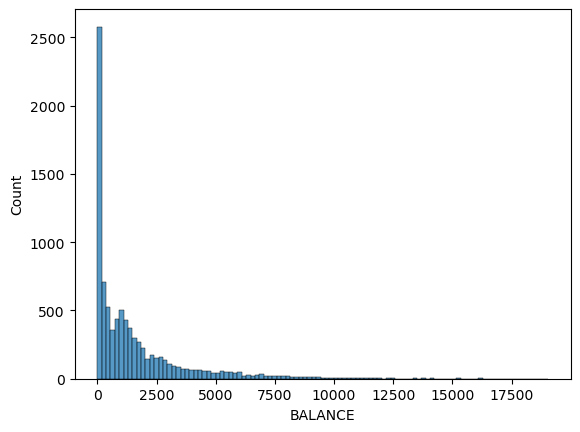

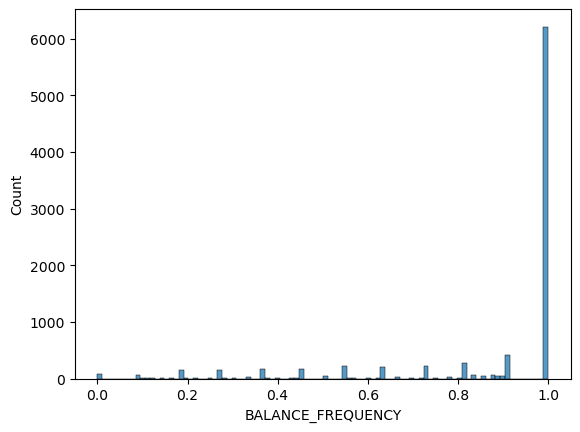

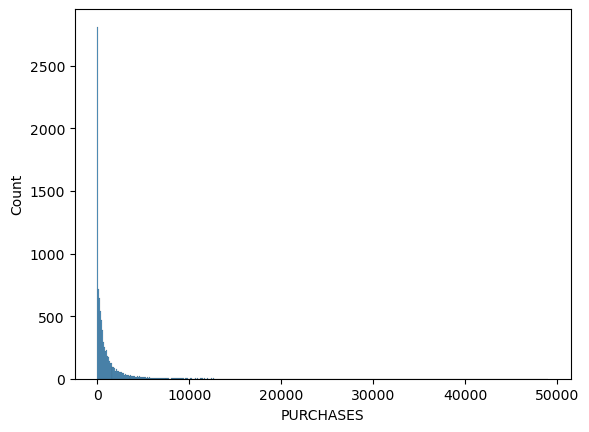

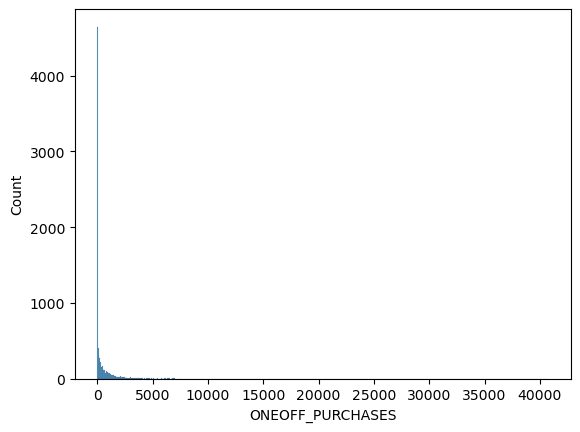

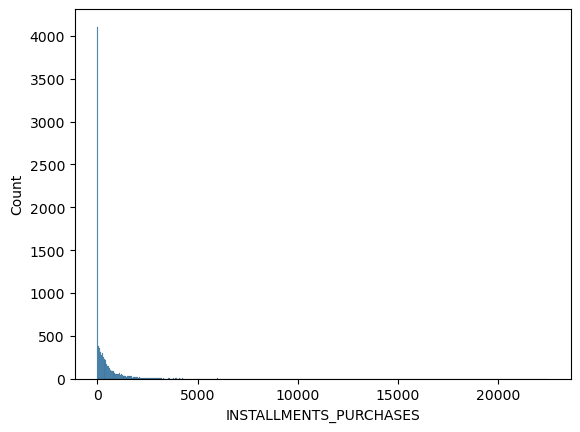

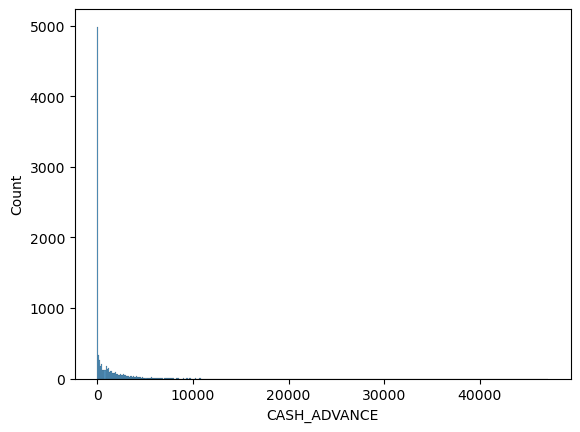

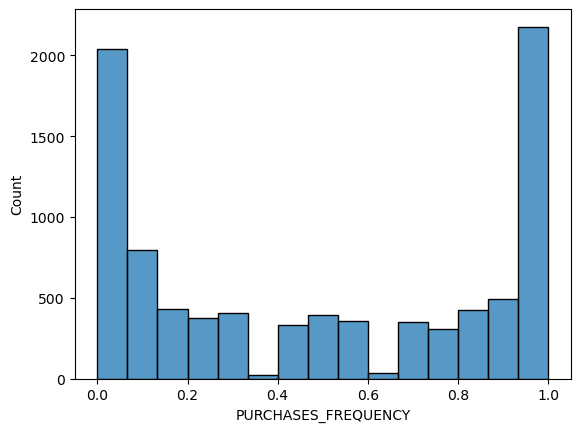

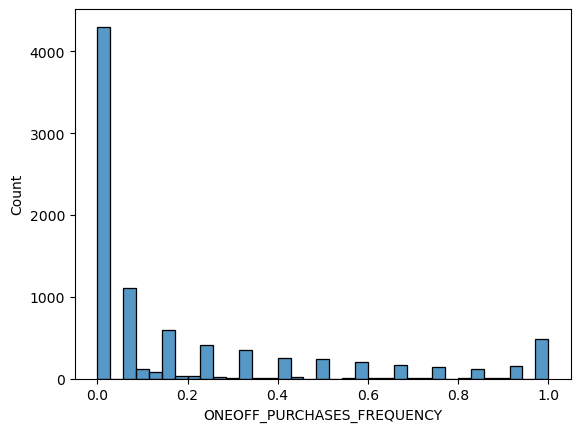

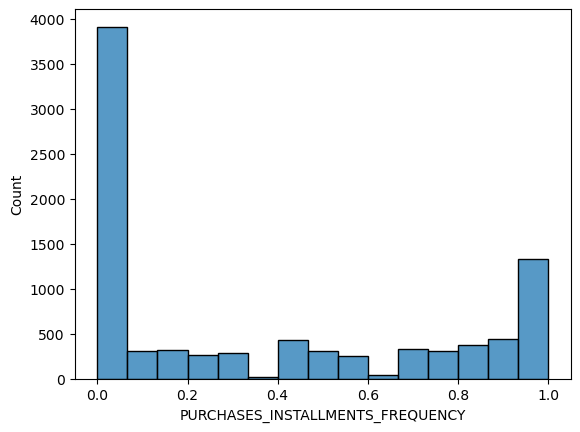

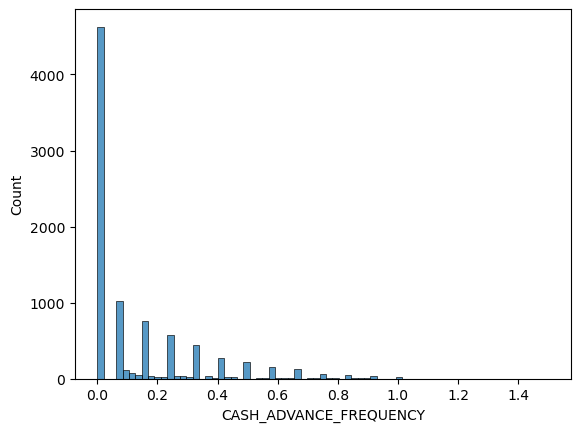

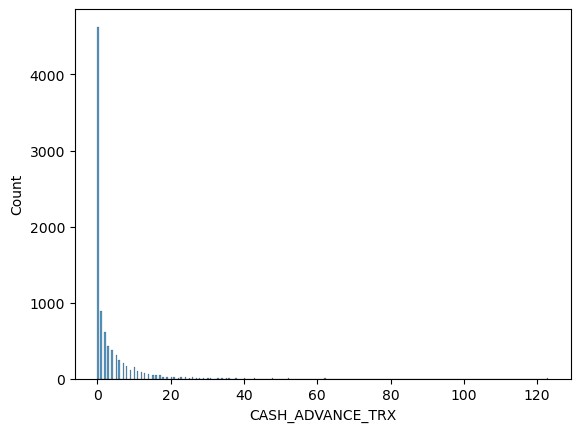

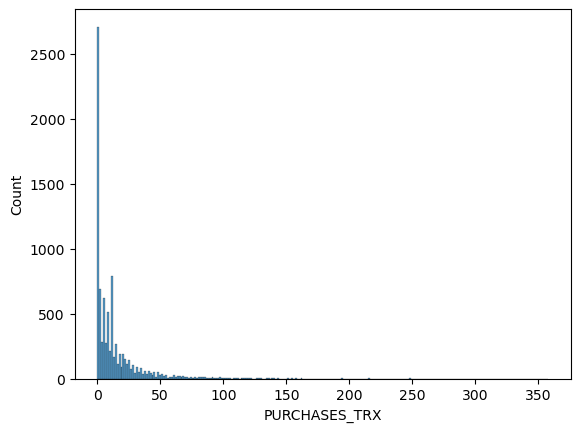

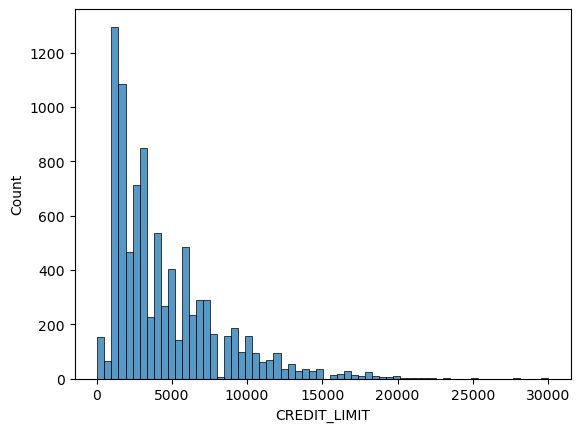

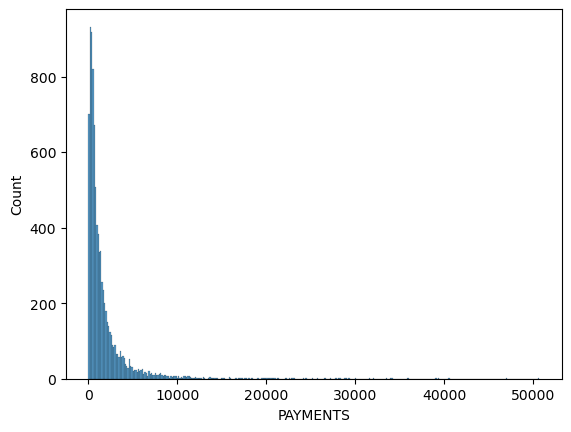

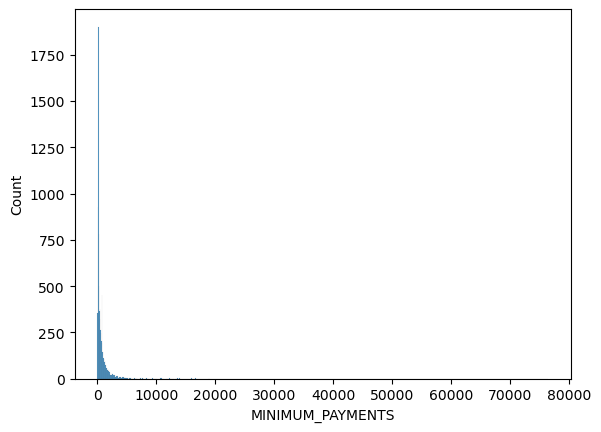

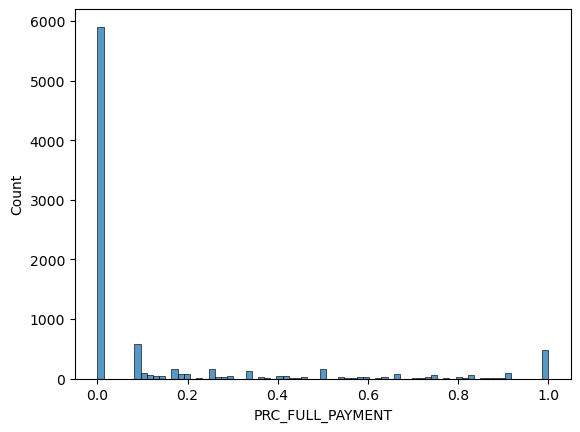

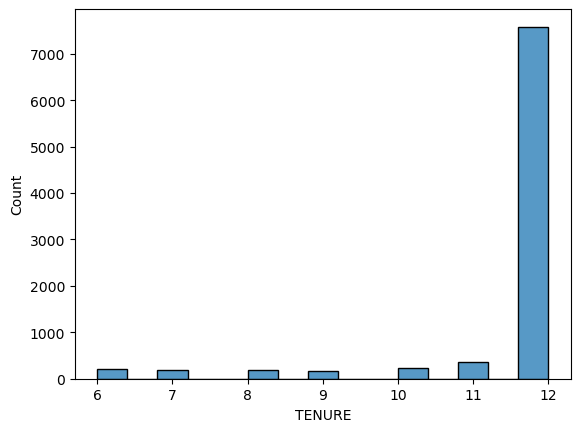

In [8]:
for i in X.columns:
    plt.figure()
    sns.histplot(X, x=i)

In [9]:
# Удалим выбросы
X = X[X['BALANCE'] < 10000]
X = X[X['PURCHASES'] < 10000]
X = X[X['ONEOFF_PURCHASES'] < 5000]
X = X[X['INSTALLMENTS_PURCHASES'] < 4000]
X = X[X['CASH_ADVANCE'] < 10000]
X = X[X['CASH_ADVANCE_TRX'] < 40]
X = X[X['CASH_ADVANCE_FREQUENCY'] <= 1.0]
X = X[X['PURCHASES_TRX'] < 150]
X = X[X['CREDIT_LIMIT'] <= 20000]
X = X[X['PAYMENTS'] < 15000]
X = X[X['MINIMUM_PAYMENTS'] < 10000]

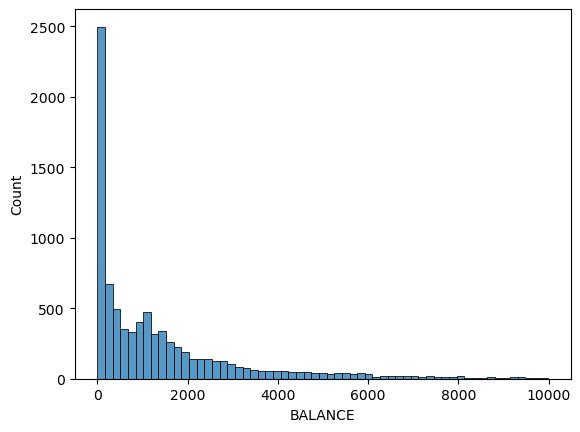

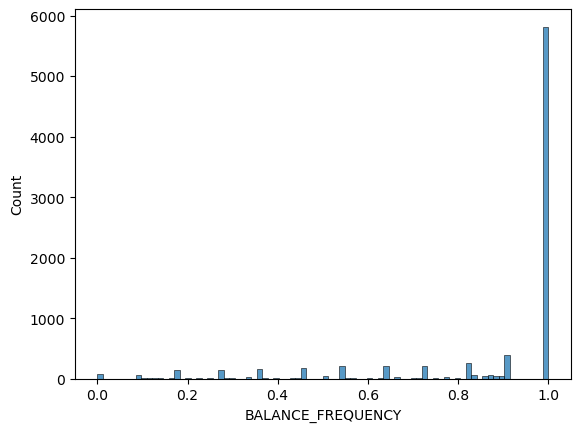

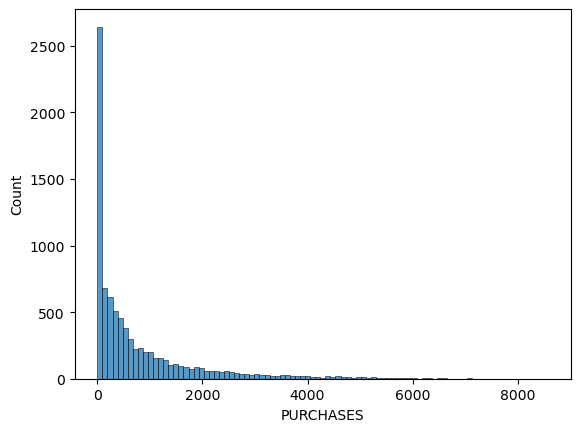

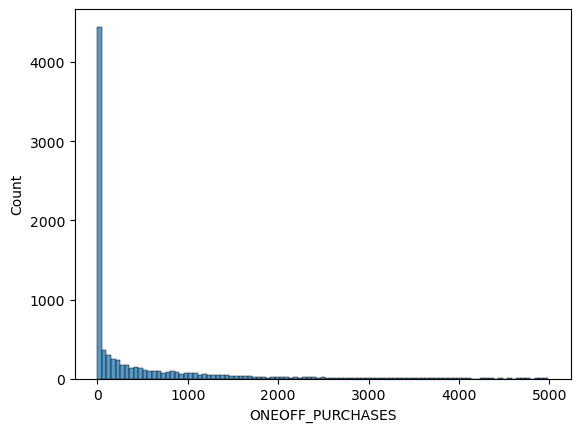

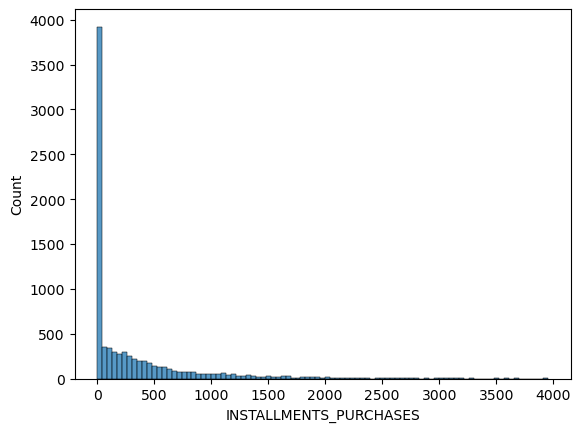

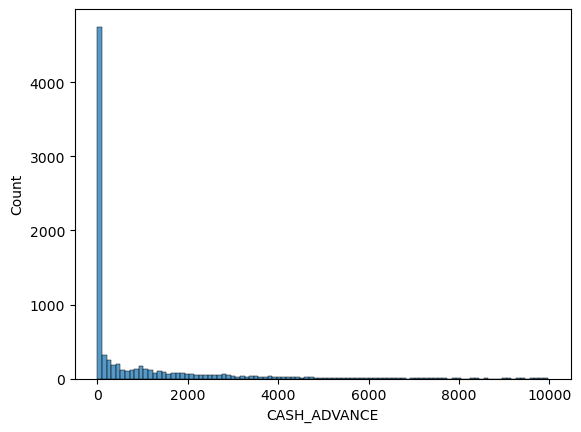

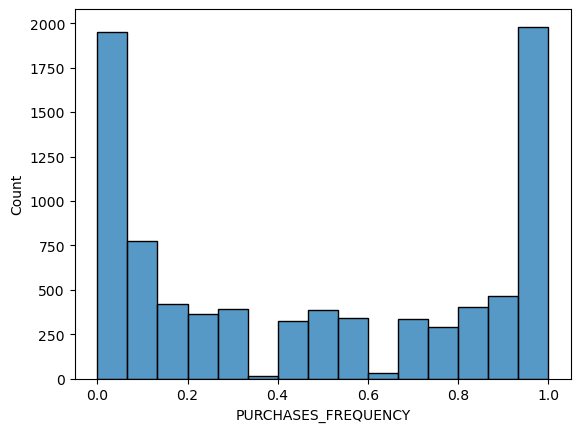

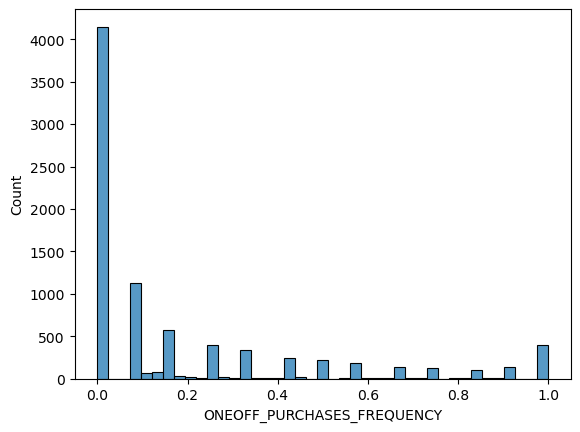

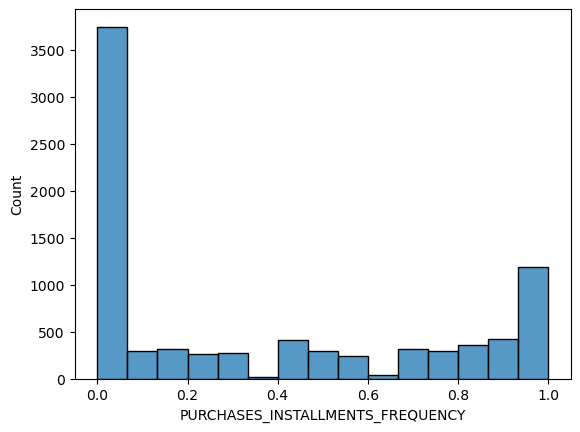

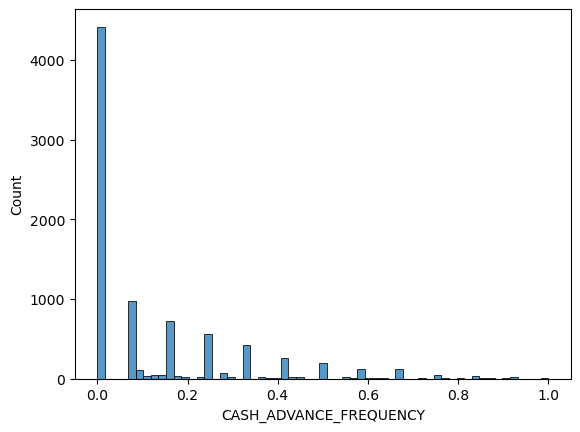

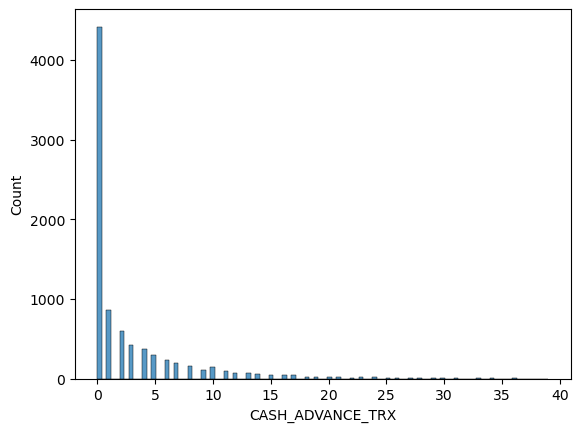

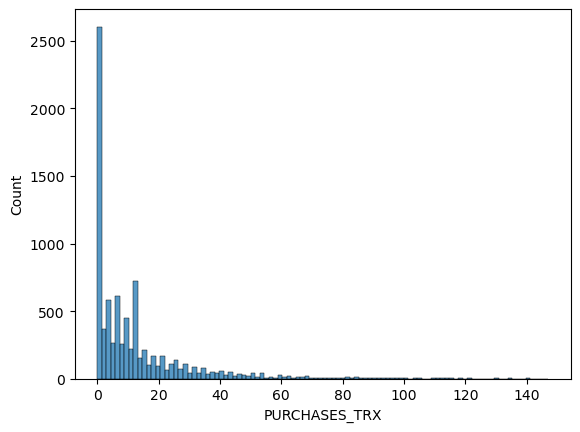

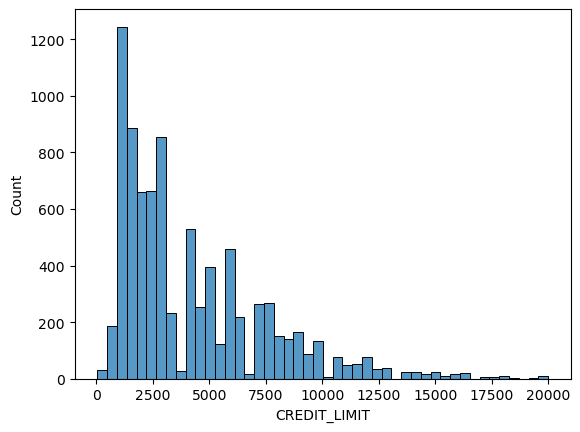

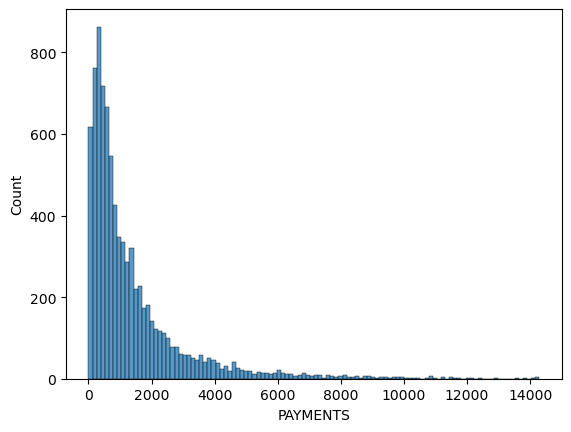

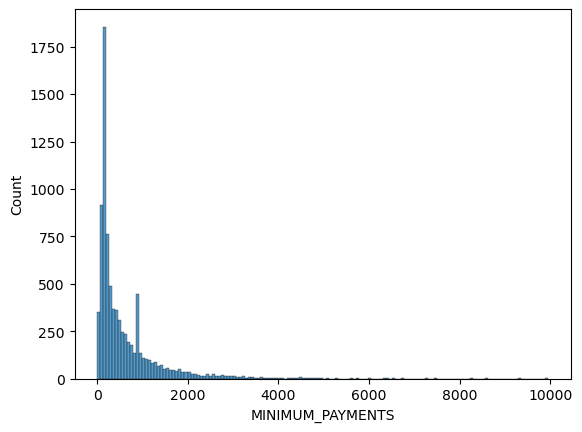

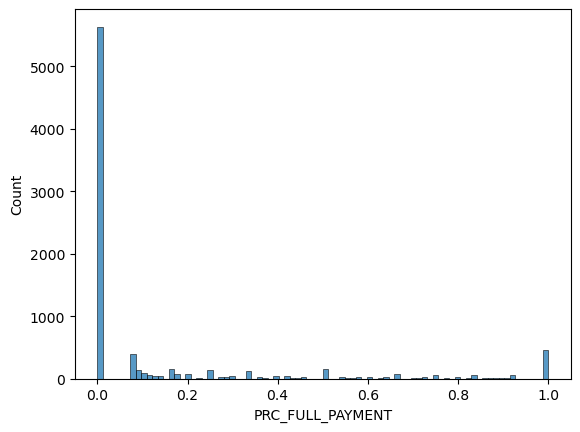

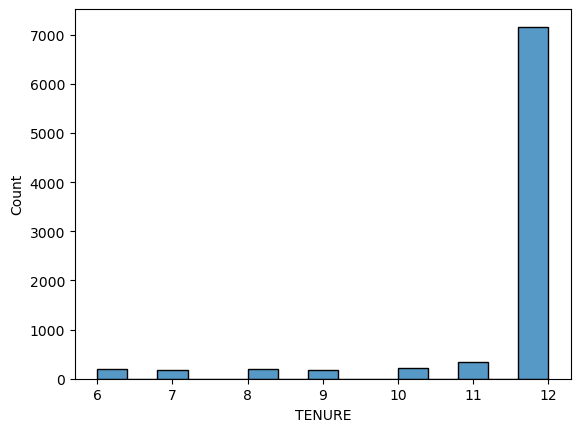

In [10]:
for i in X.columns:
    plt.figure()
    sns.histplot(X, x=i)

In [11]:
X.shape

(8483, 17)

In [12]:
# Нормализуем данные. Используем Robust, т.к. много выбросов
transformer = RobustScaler().fit(X)
X = pd.DataFrame(transformer.transform(X), columns=X.columns)

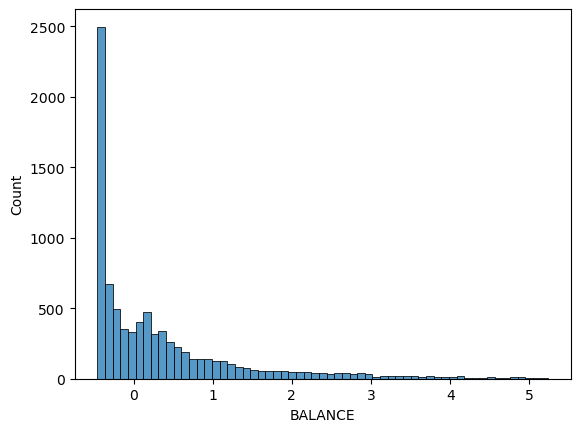

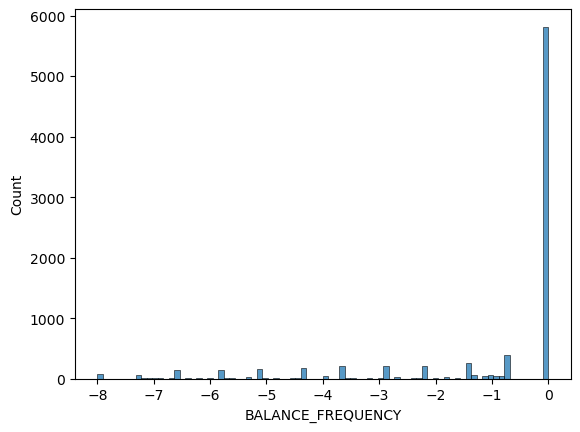

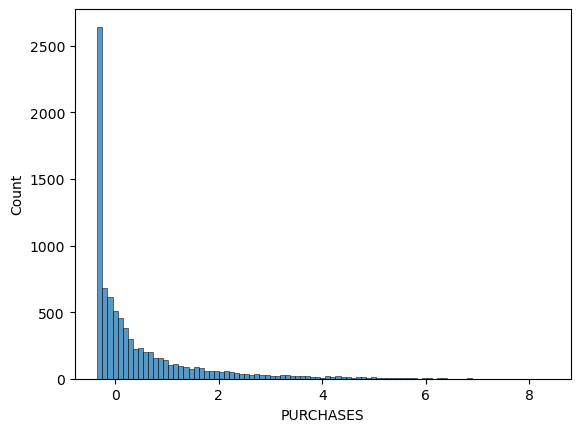

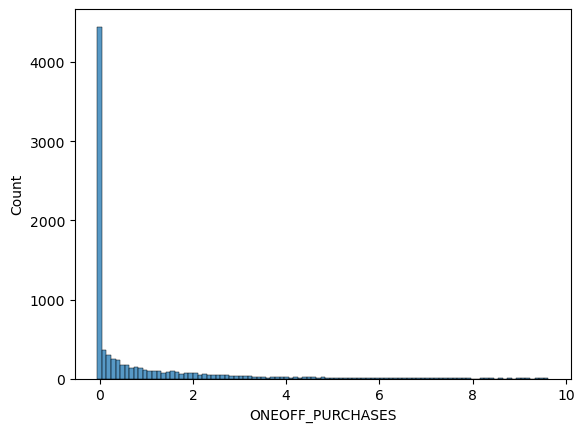

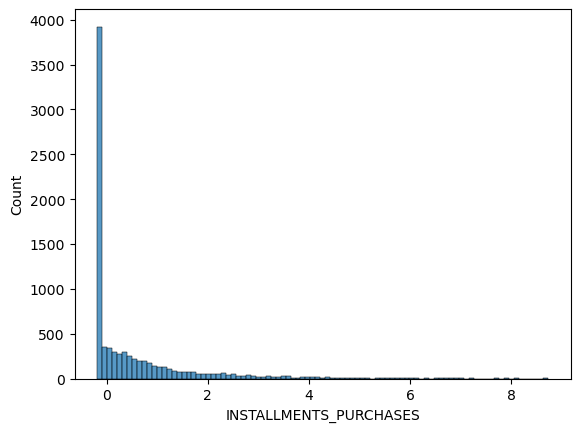

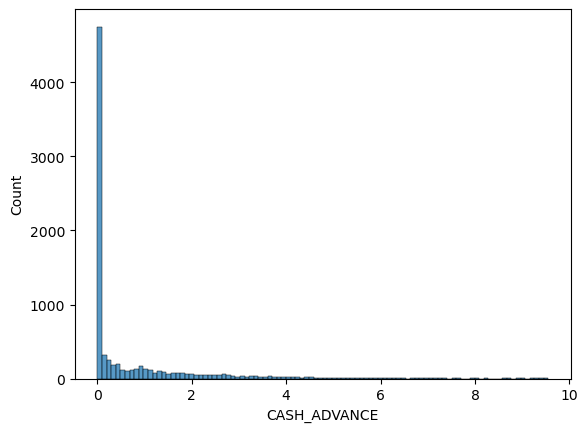

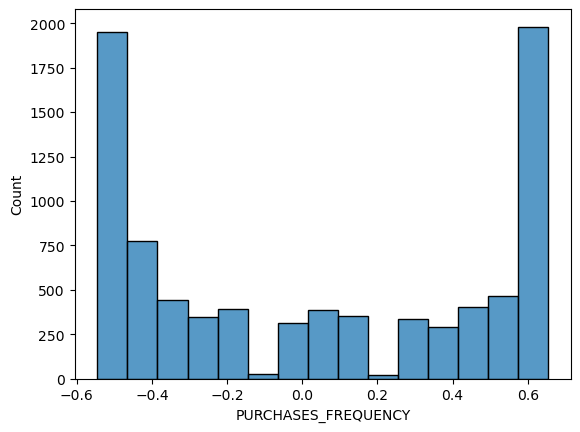

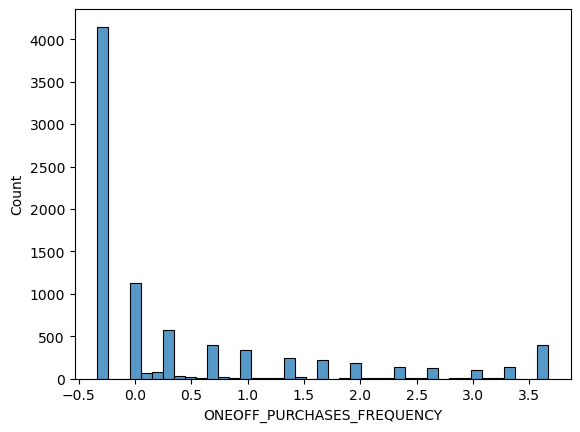

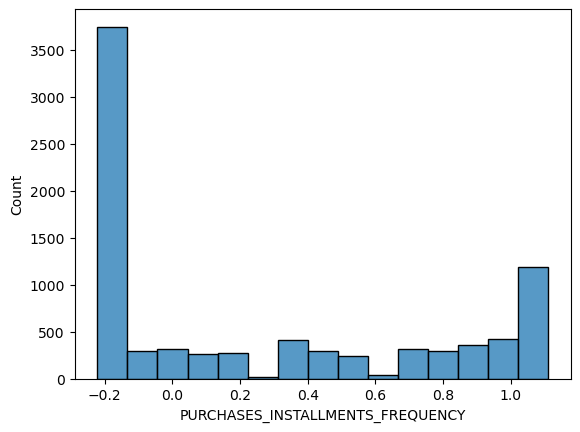

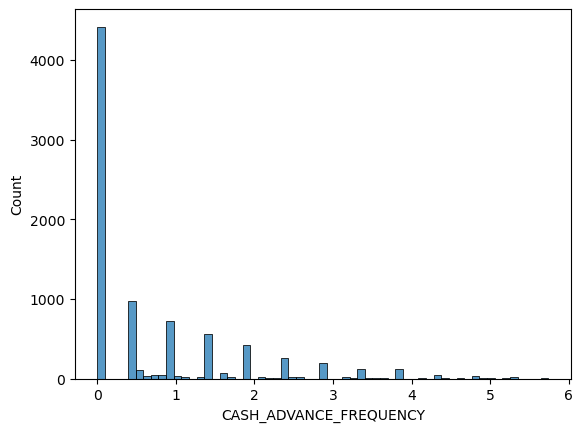

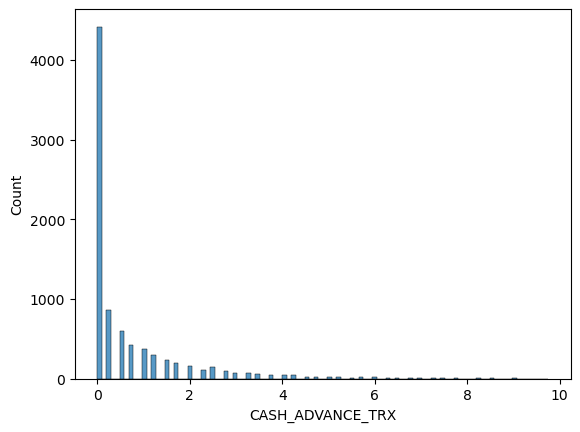

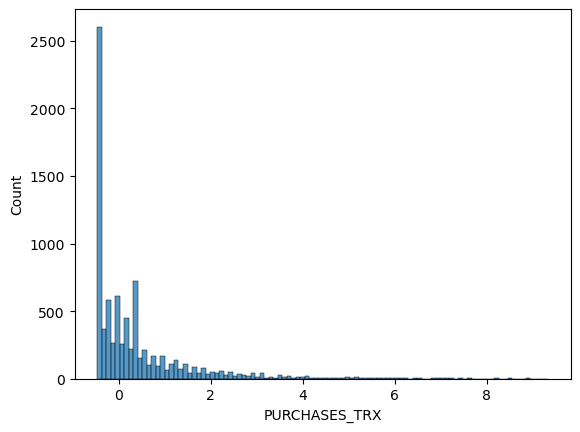

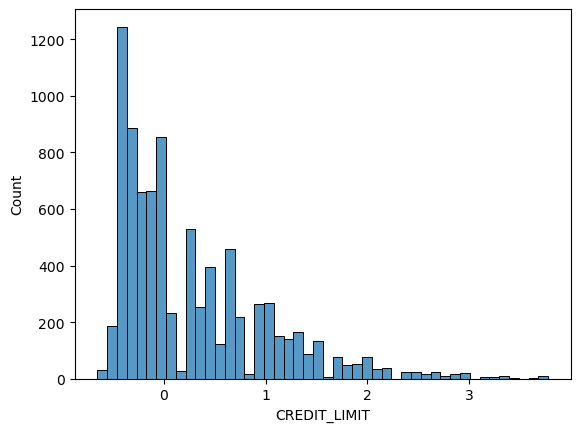

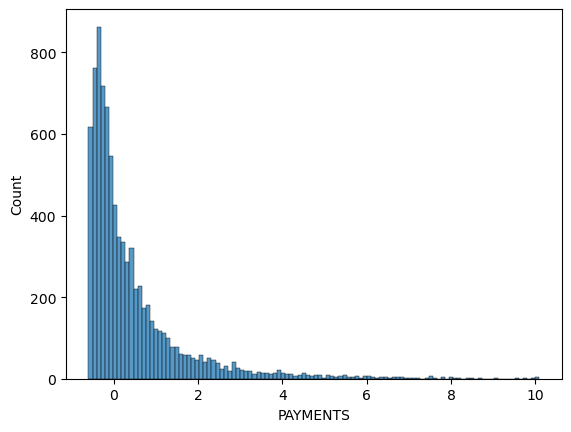

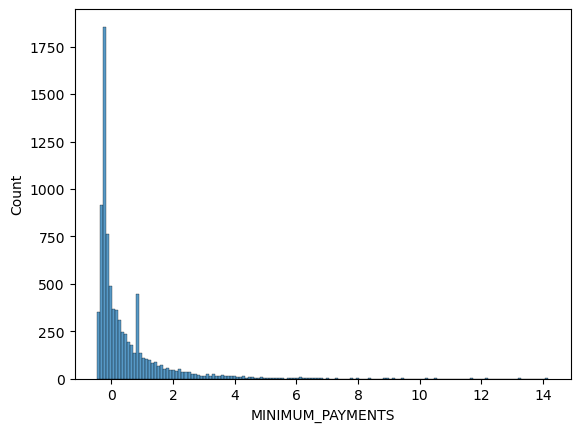

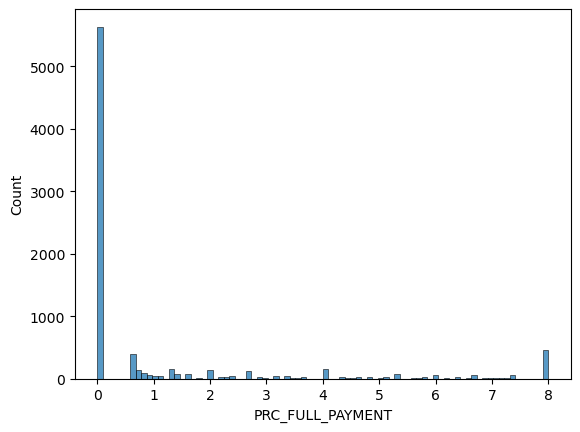

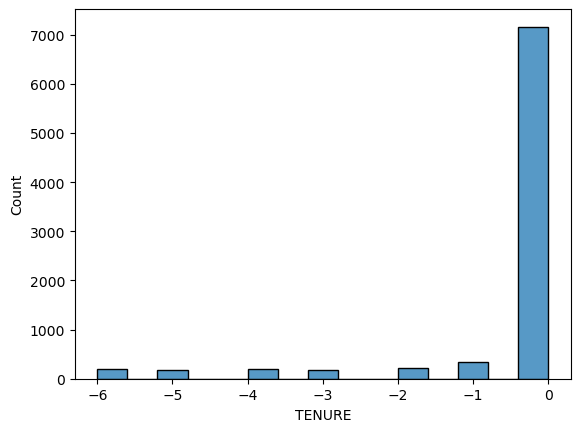

In [13]:
for i in X.columns:
    plt.figure()
    sns.histplot(X, x=i)

In [14]:
def distance_by_n(x, n):
    model = KMeans(n_clusters=n)
    model.fit(x)
    return model.inertia_

Text(0.5, 1.0, 'Elbow method')

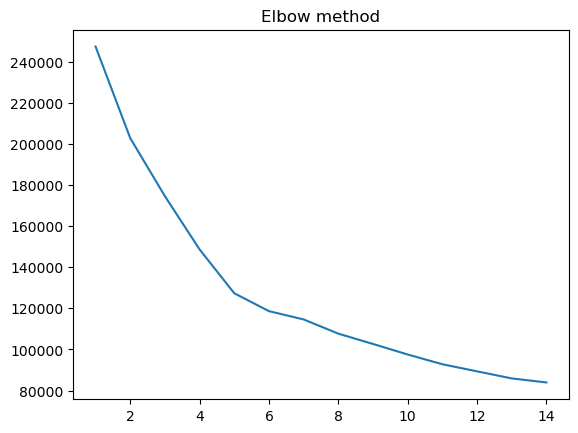

In [15]:
distances = [distance_by_n(X, n) for n in range(1, 15)]
plt.plot(range(1, 15), distances)
plt.title('Elbow method')

In [16]:
model = KMeans(n_clusters=8)
model_labels = model.fit_predict(X)

In [17]:
def plot_dist(X):
    for i in X.columns:
        if i == 'Type':
            break
        plt.figure()
        sns.histplot(X, x=i, hue='Type')

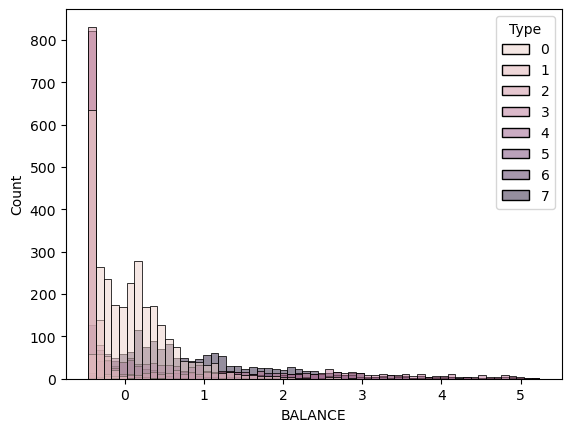

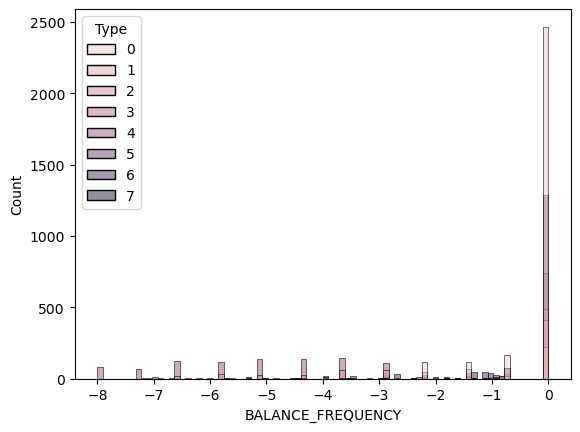

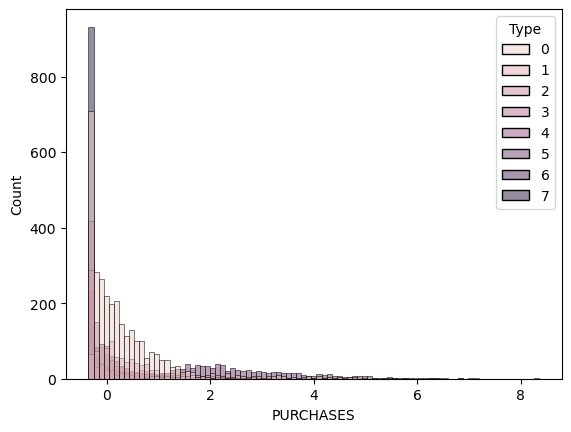

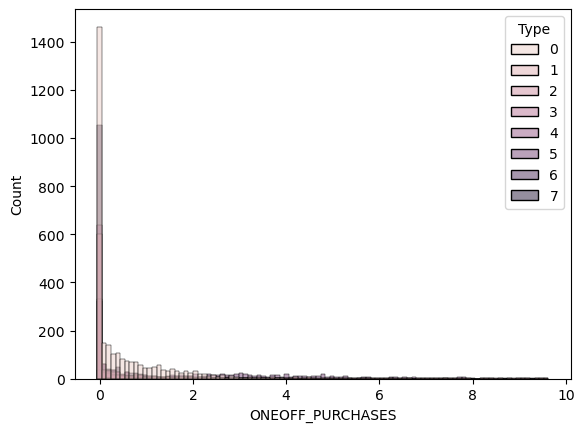

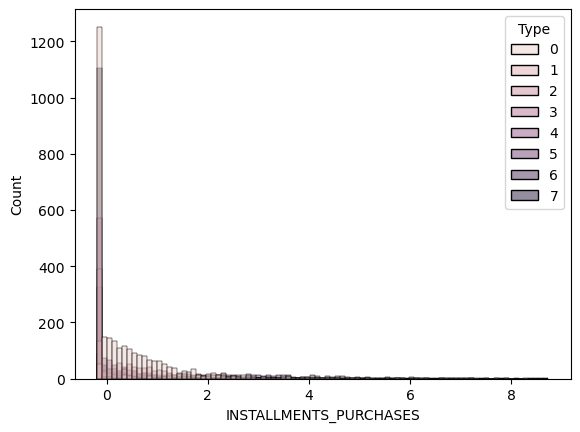

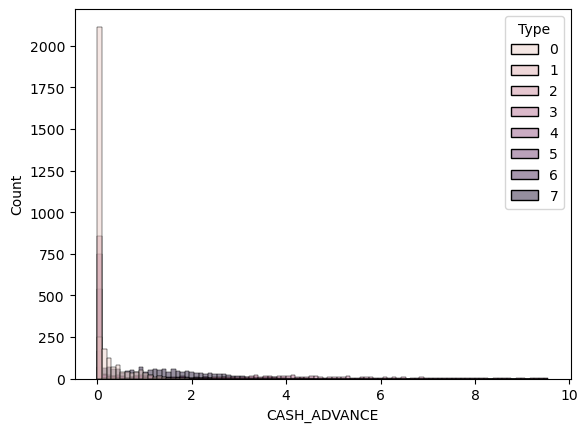

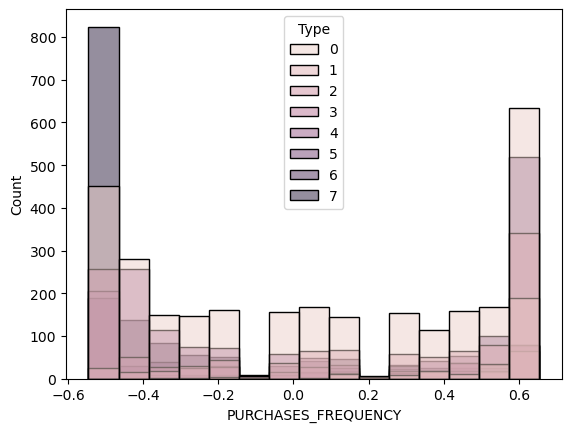

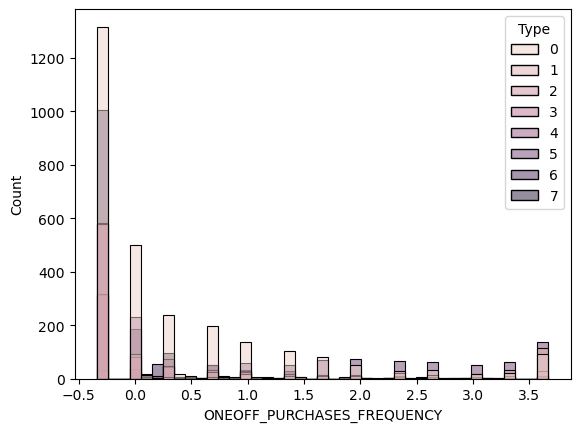

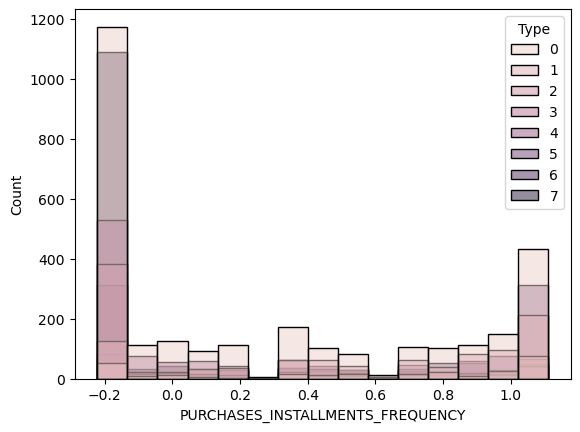

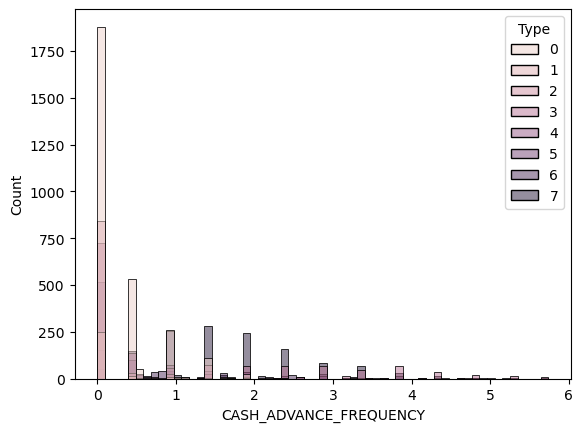

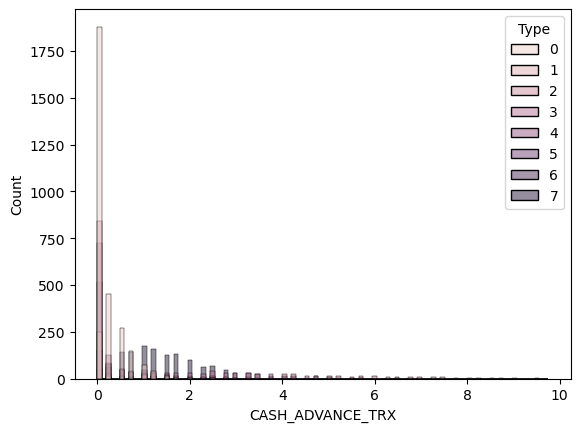

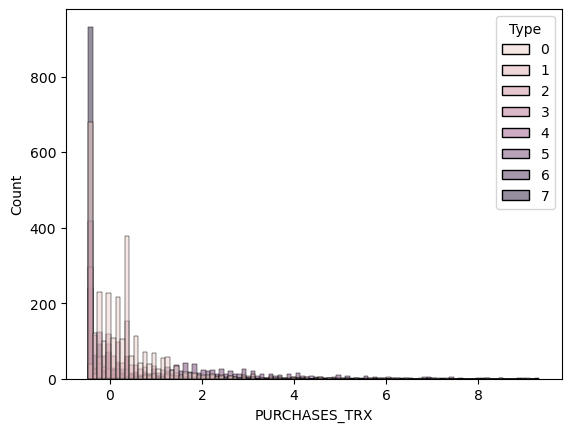

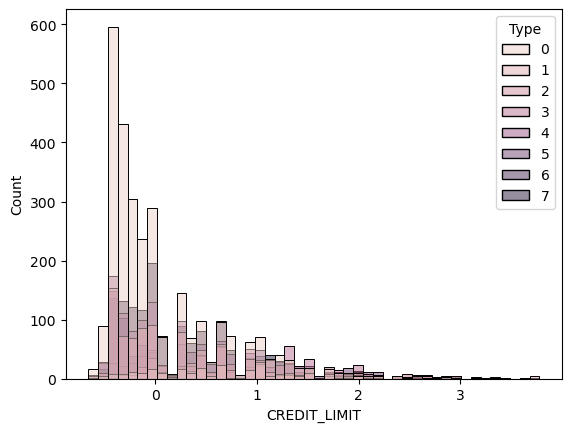

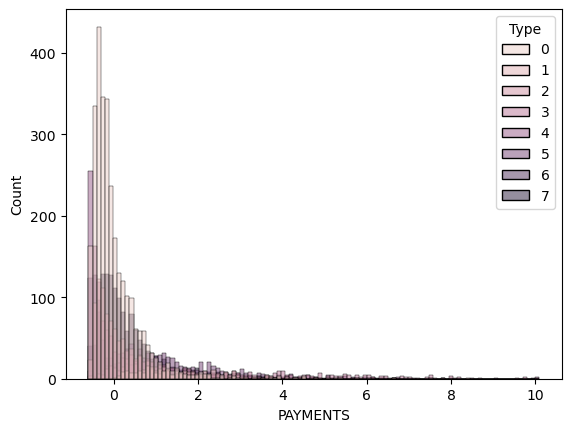

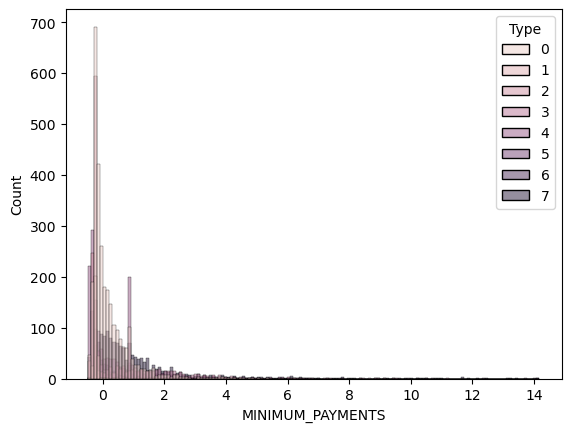

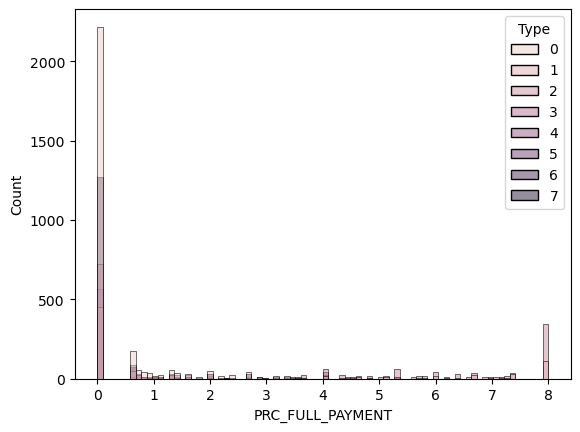

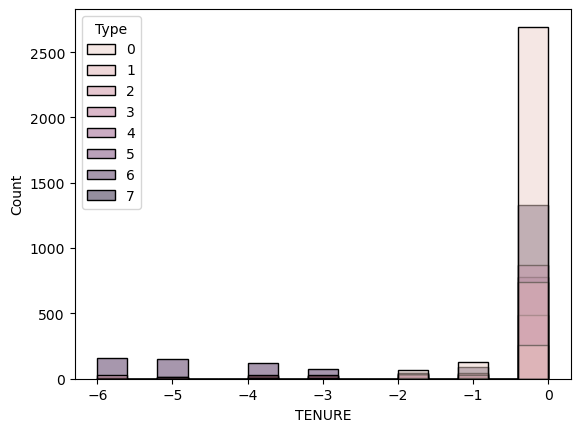

In [18]:
X['Type'] = model_labels
plot_dist(X)

Есть корреляция с BALANCE, PURCHASES, CASH_ADVANCE, CREDIT_LIMIT, PAYMENTS, TENURE, причем чем ниже класс, тем обеспеченность клиента.

# Medium

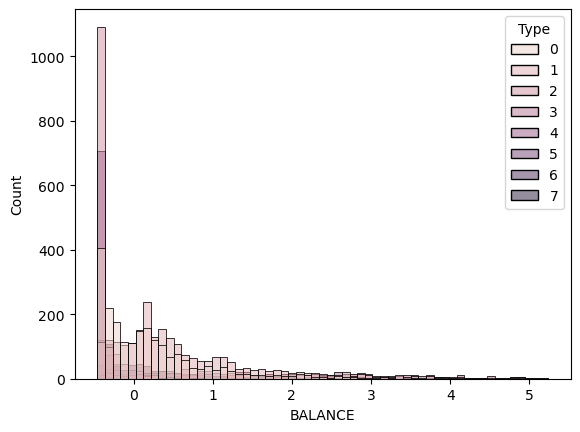

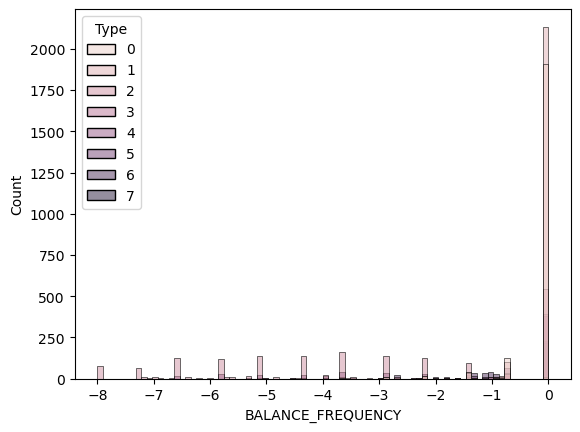

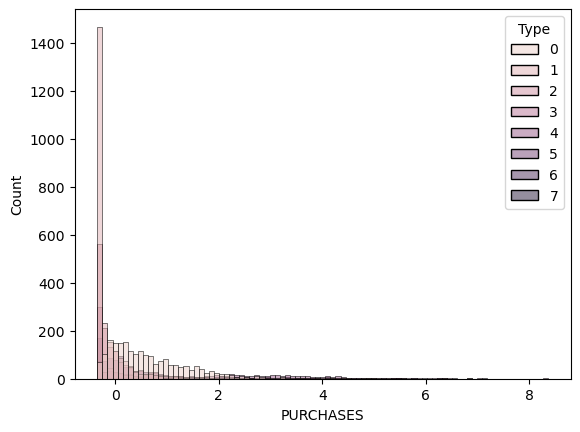

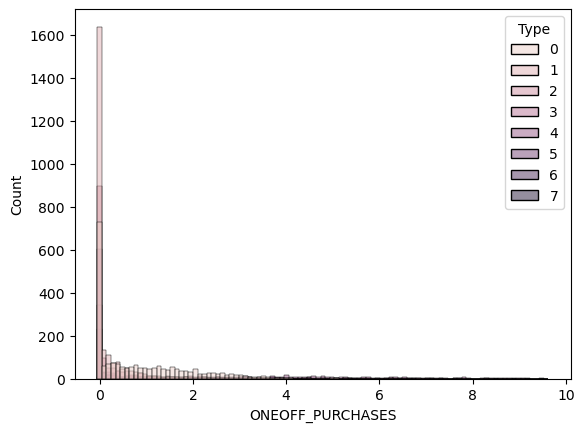

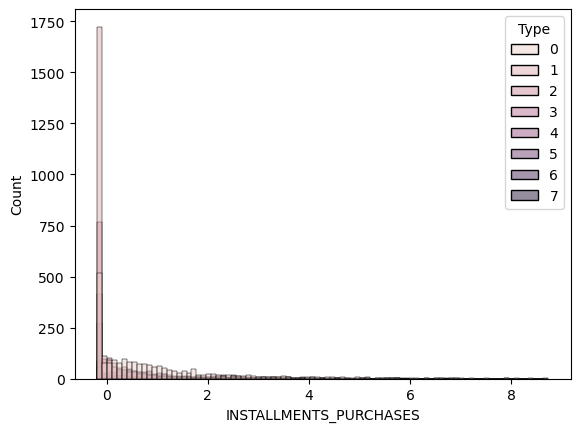

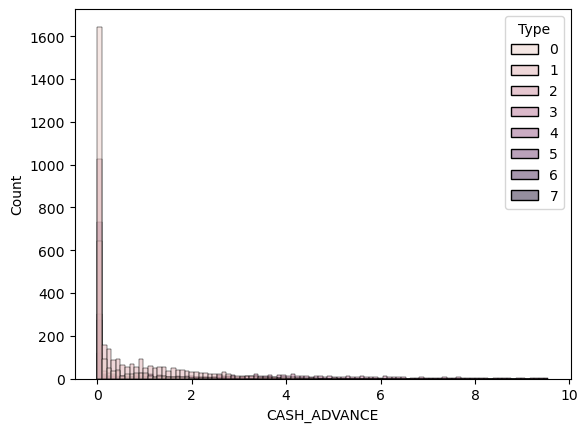

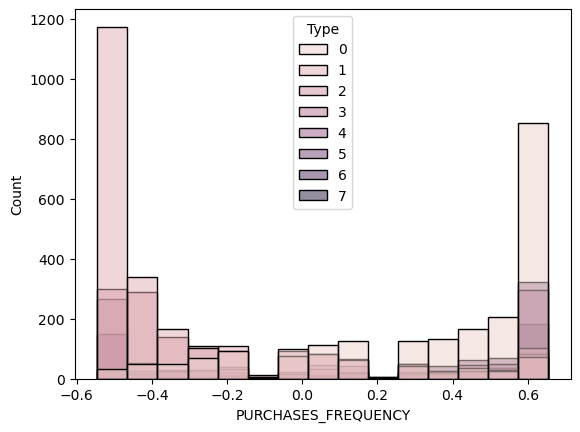

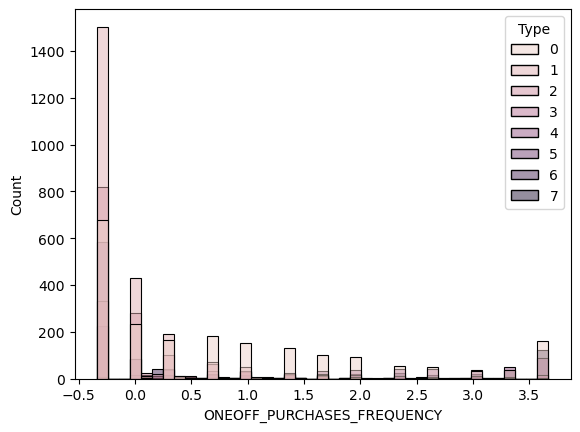

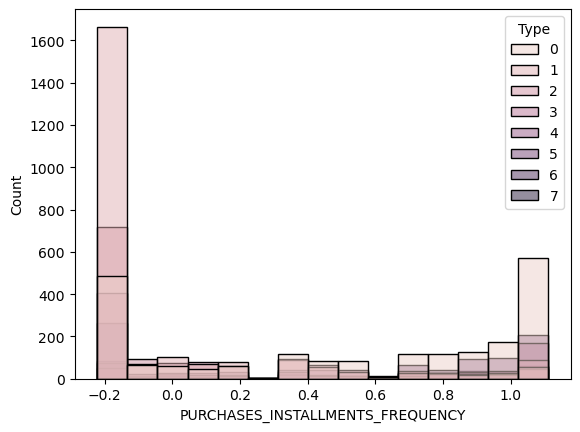

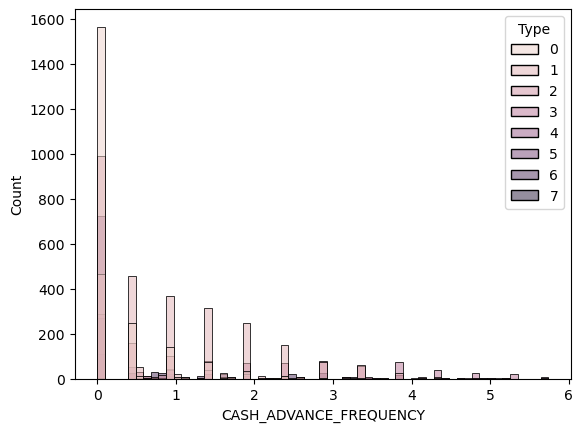

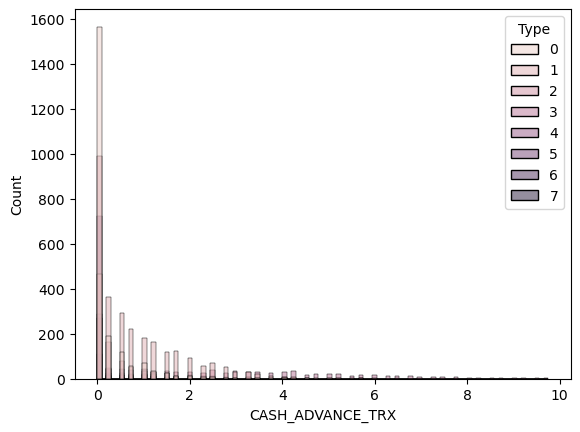

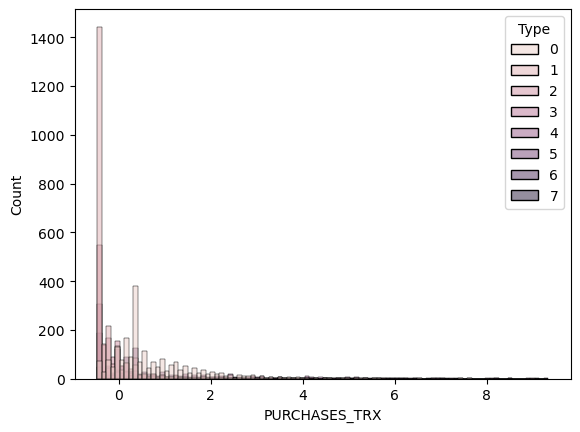

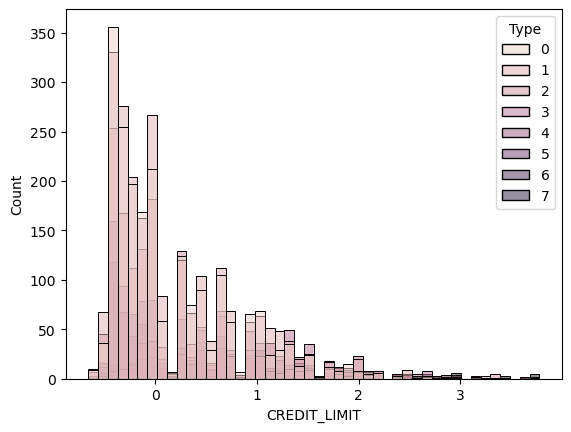

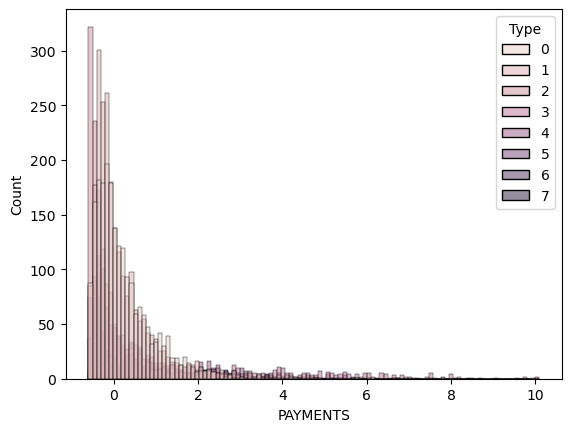

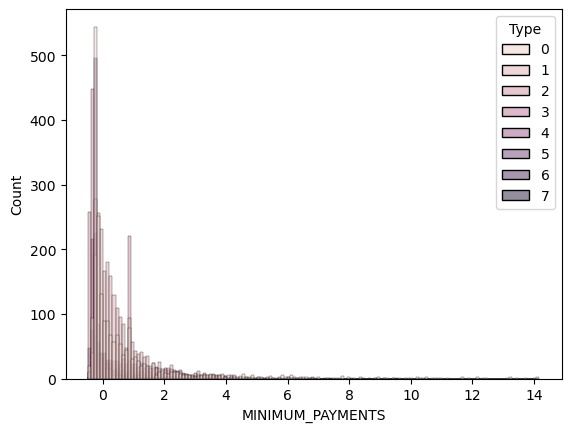

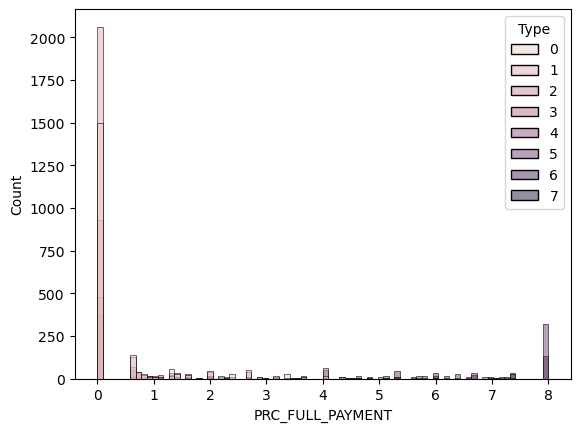

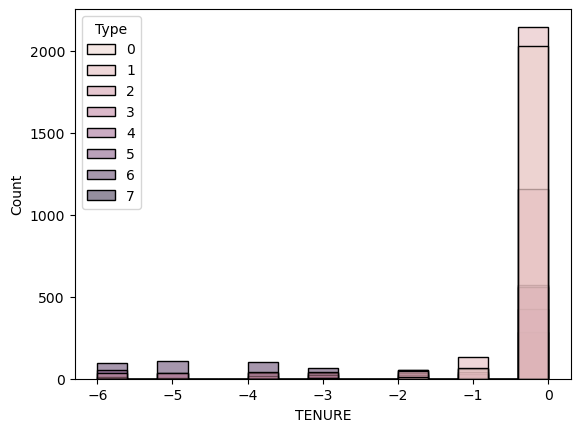

In [19]:
X = X.drop(columns=['Type'])
agg_result = AgglomerativeClustering(8).fit_predict(X)
X['Type'] = agg_result
plot_dist(X)

У иерархической кластеризации разделение более четкое, возможно, в силу того, что она не использует рандомизированные методы.

In [20]:
X = X.drop(columns=['Type'])

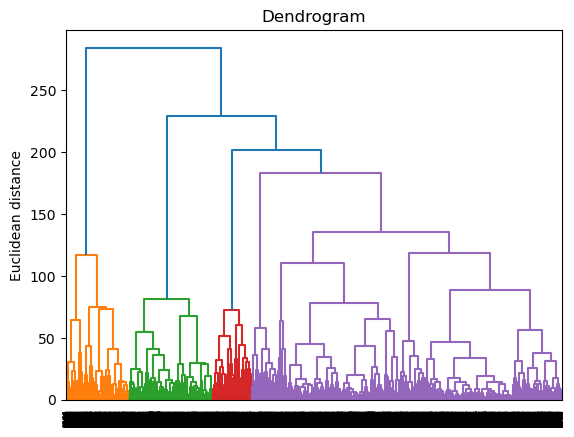

In [21]:
Z = linkage(X, method = 'ward')

#plotting dendrogram
dendro = dendrogram(Z)
plt.title('Dendrogram')
plt.ylabel('Euclidean distance')
plt.show()

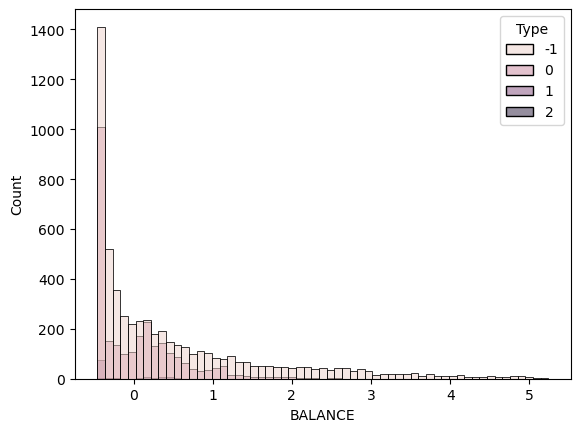

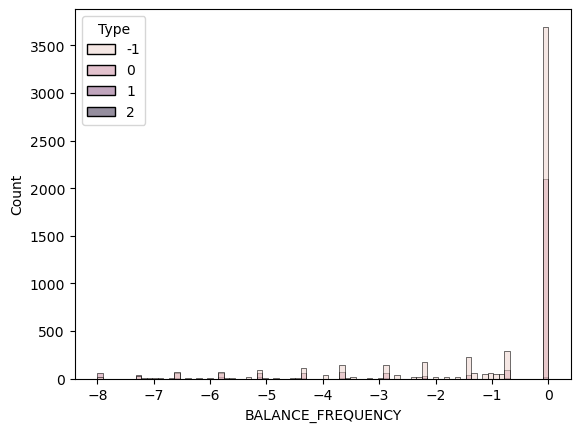

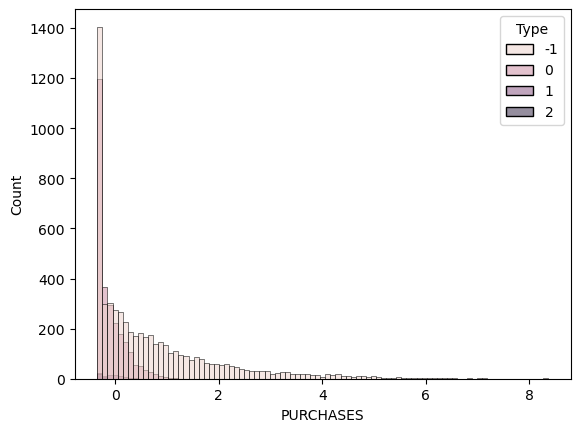

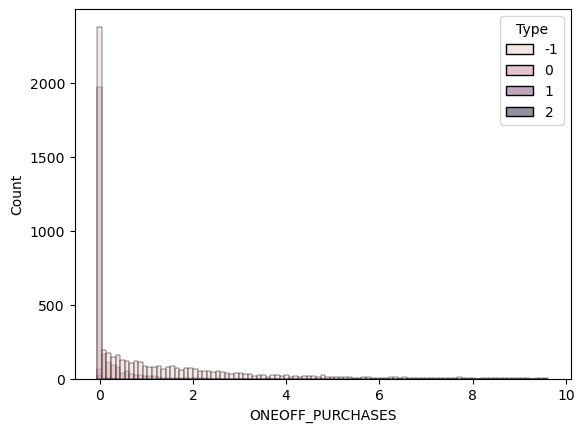

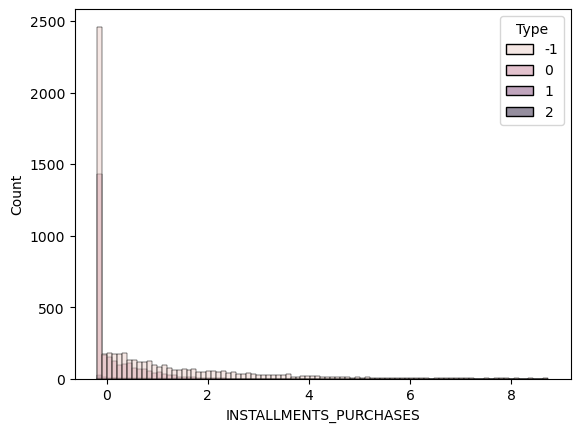

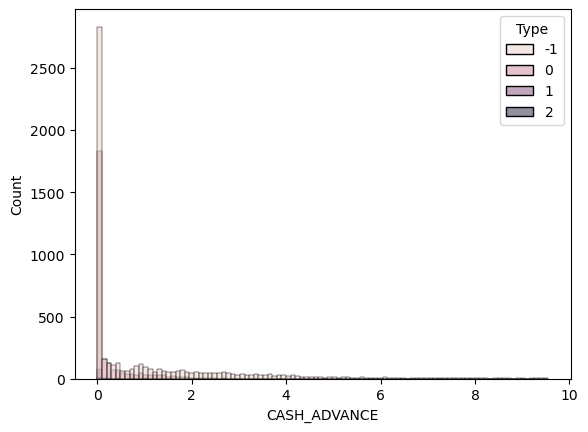

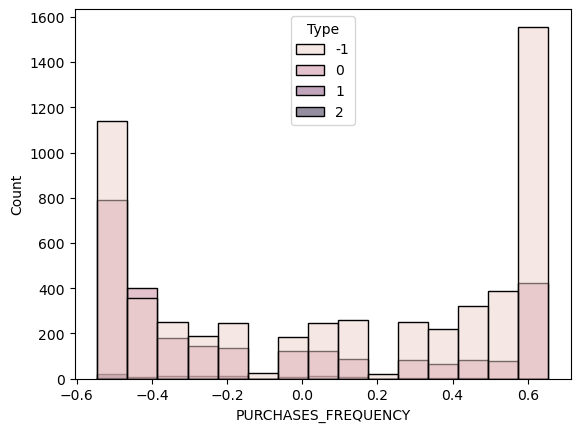

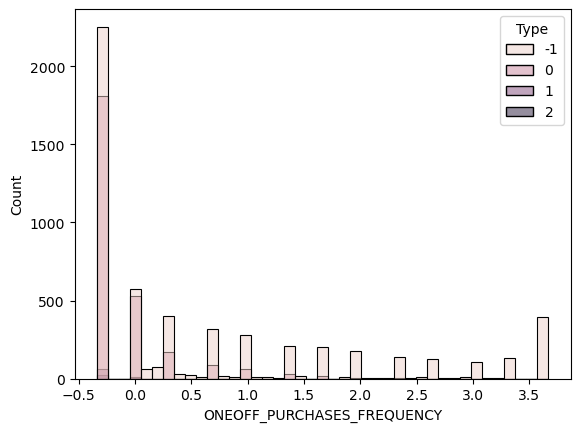

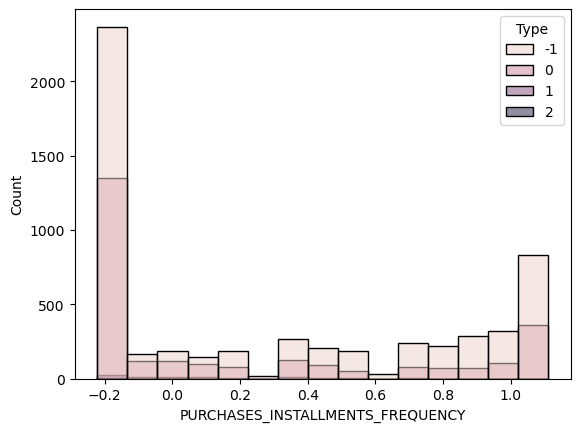

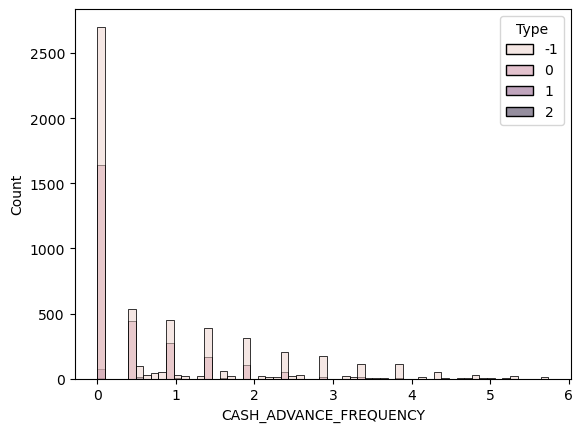

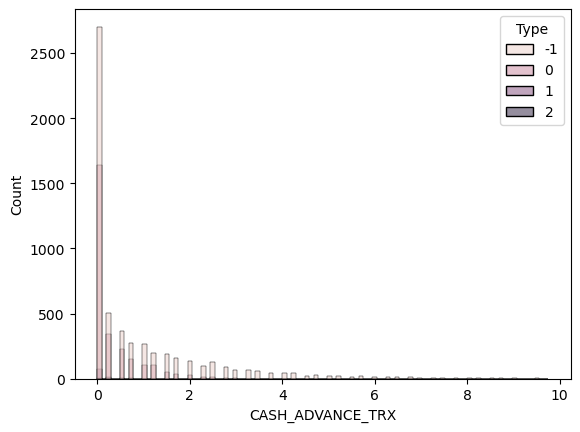

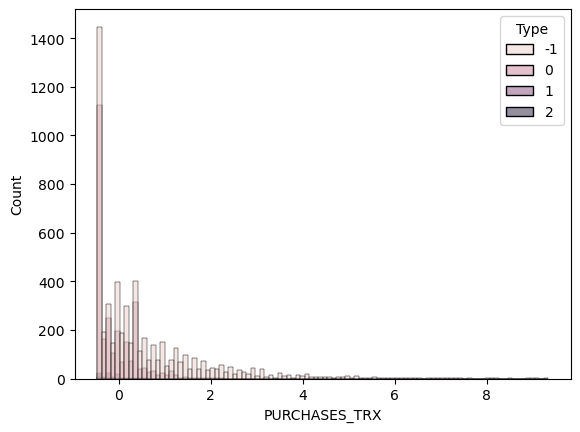

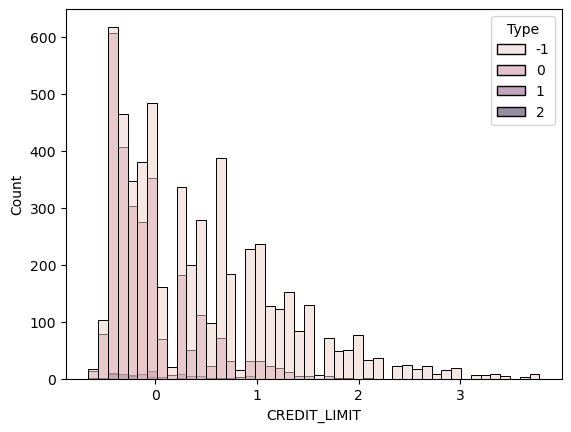

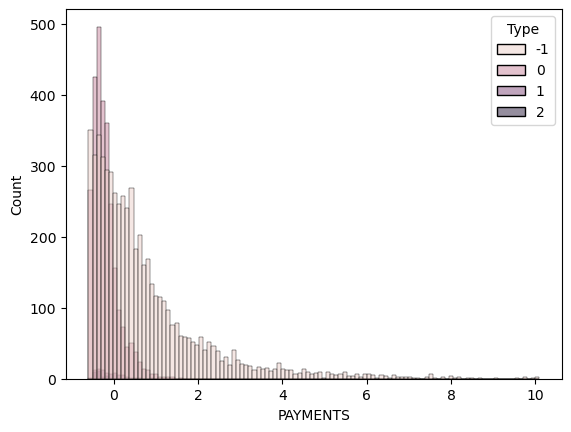

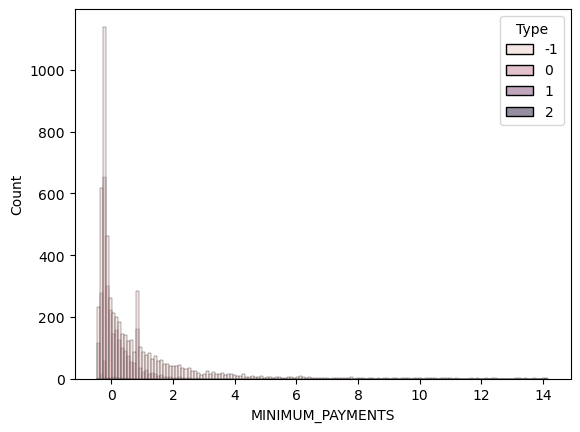

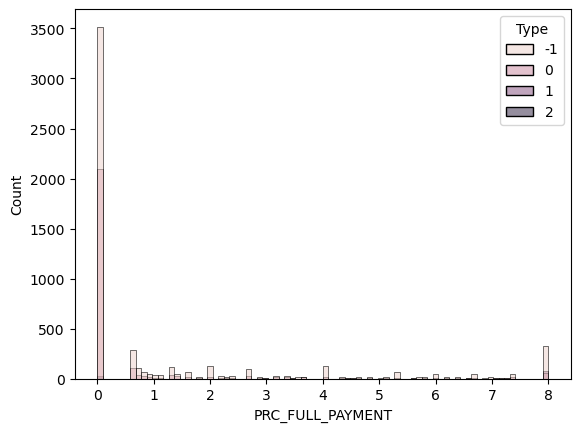

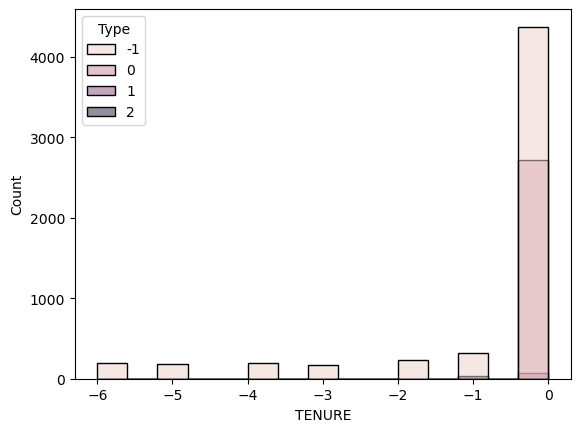

In [22]:
res = DBSCAN(eps=1, min_samples=15).fit_predict(X)
X['Type'] = res
plot_dist(X)

In [23]:
X[X['Type'] >= 1].shape

(105, 18)

DBSCAN очень хорошо фильтрует выбросы. Классам 2-6 принадлежат очень мало значений, их можно выкинуть, поскольку при классификации вместе с ними не получается получить никакой содержательной информации про остальные сэмплы. 

У датасета ужасное распределение, поэтому при переборе гиперпараметров выяснилось, что DBSCAN дает содеражетельную информацию только о двух классах (выбросы и не выбросы) почти при всех гиперпараметрах.

In [24]:
X_clean = X[X['Type'] < 1]
X_clean.drop(inplace=True, columns=['Type'])
X_clean.shape

(8378, 17)

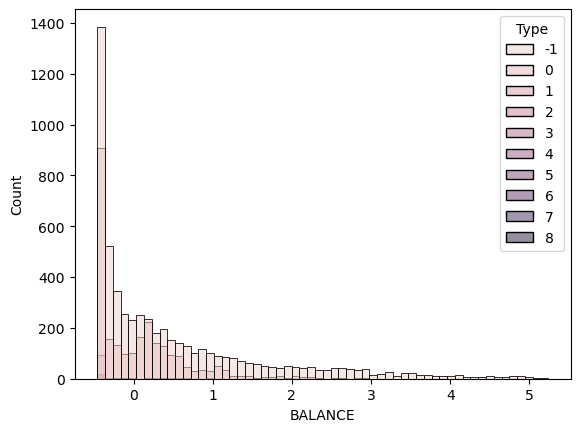

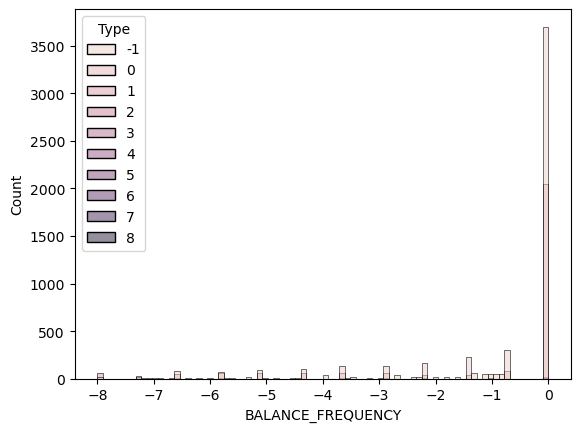

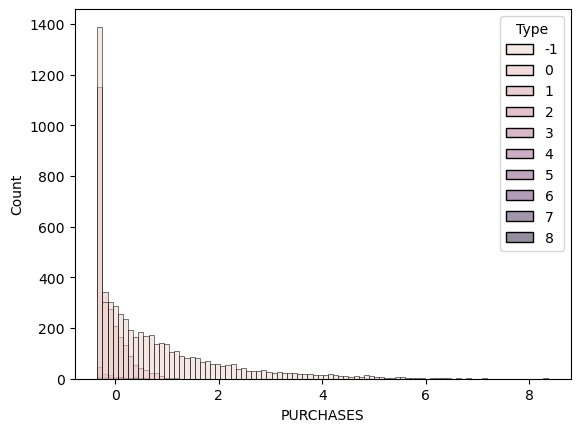

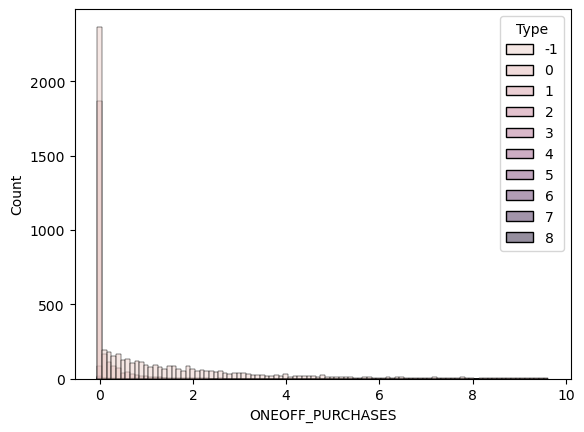

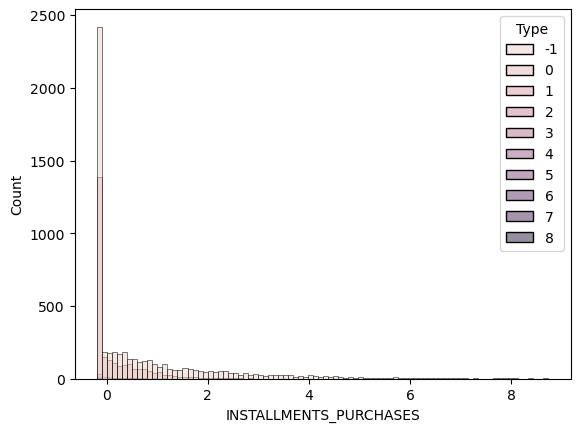

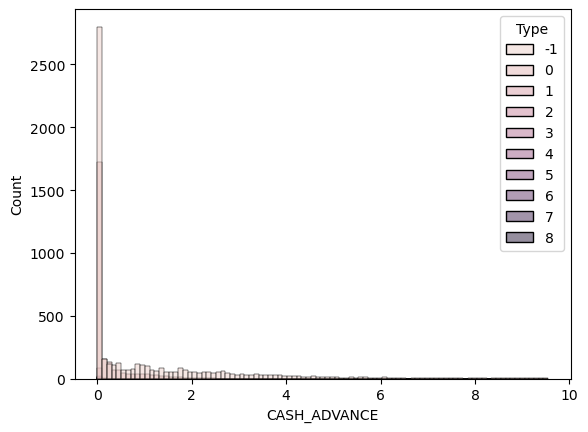

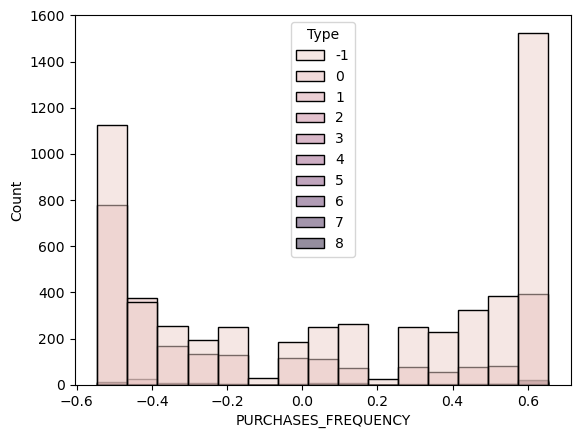

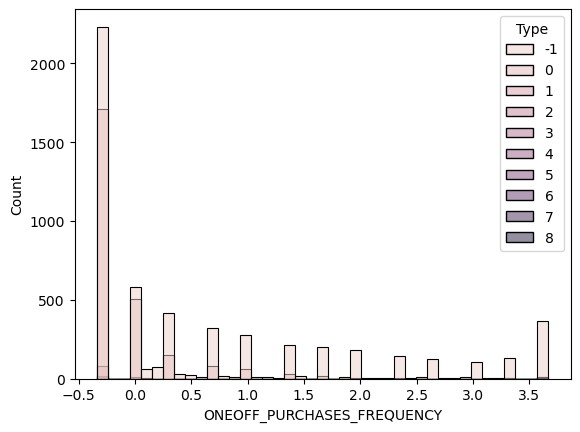

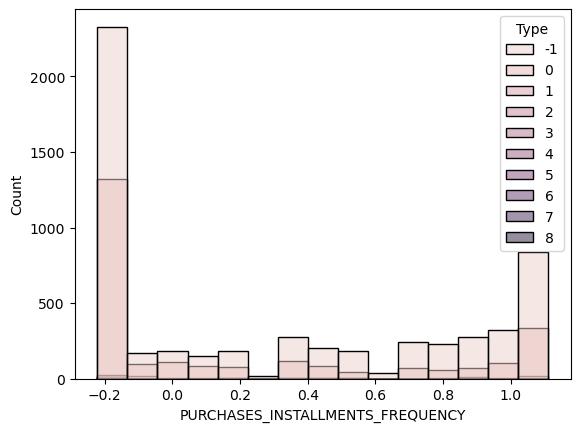

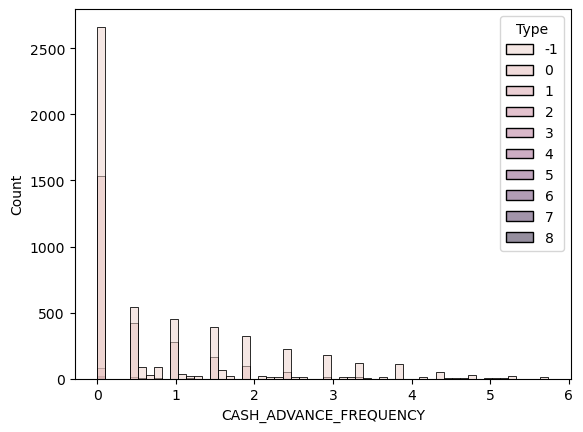

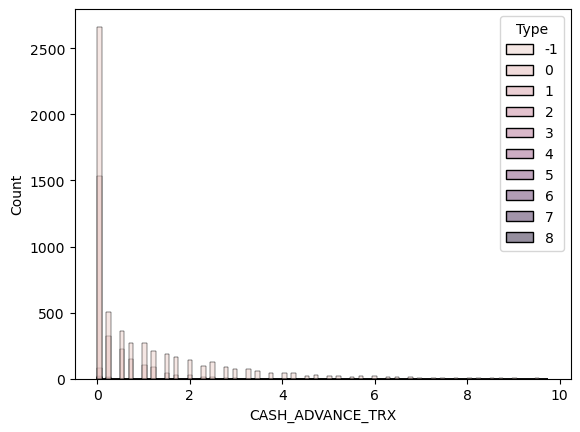

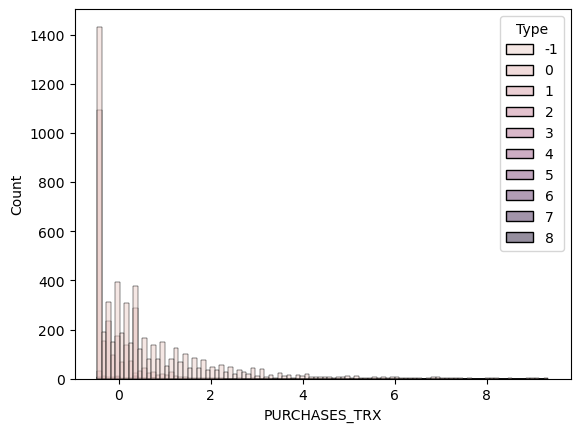

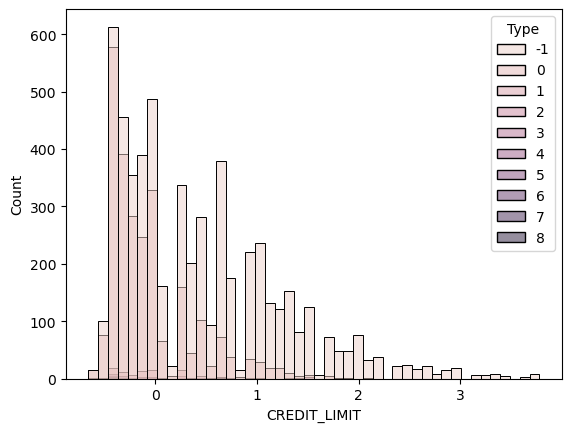

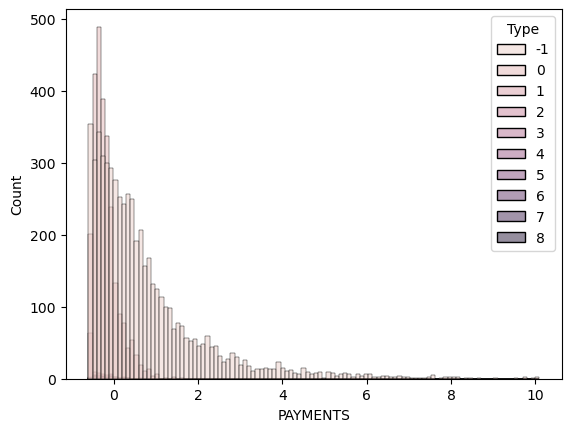

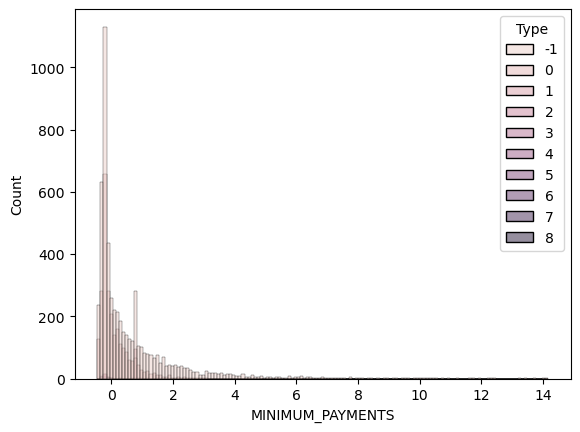

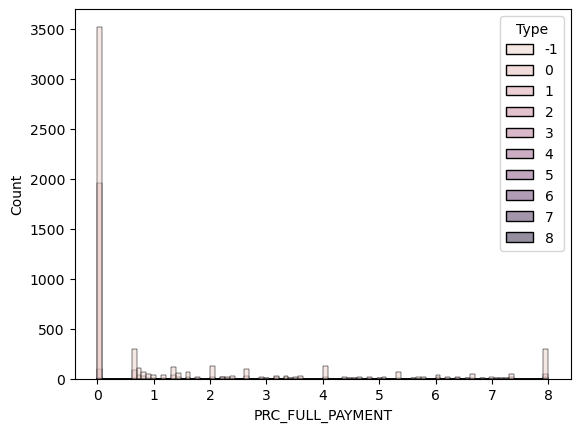

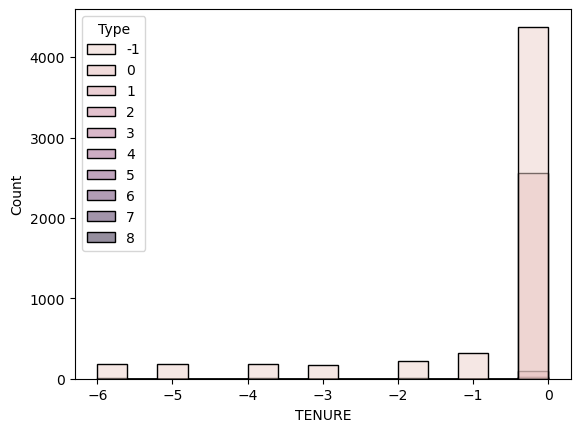

In [25]:
res = DBSCAN(eps=0.9, min_samples=8).fit_predict(X_clean)
X_clean['Type'] = res
plot_dist(X_clean)

In [26]:
X_clean[X_clean['Type'] >= 0].shape

(2737, 18)

In [27]:
X = X.drop(columns=['Type'])

In [28]:
clustering = SpectralClustering(n_clusters=7, assign_labels='discretize', random_state=0).fit(X)
X['Type'] = clustering.labels_

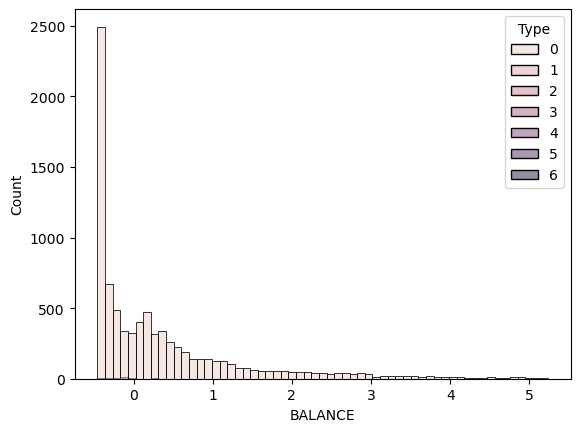

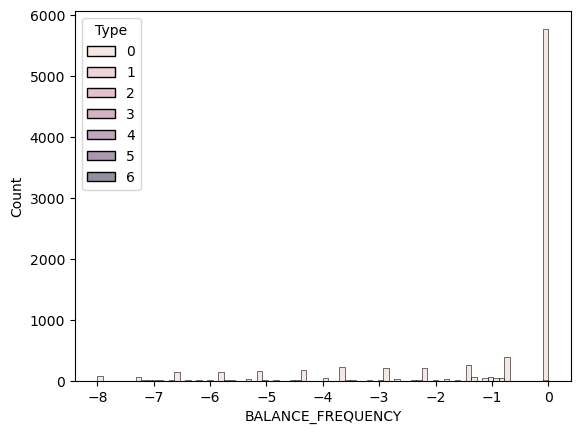

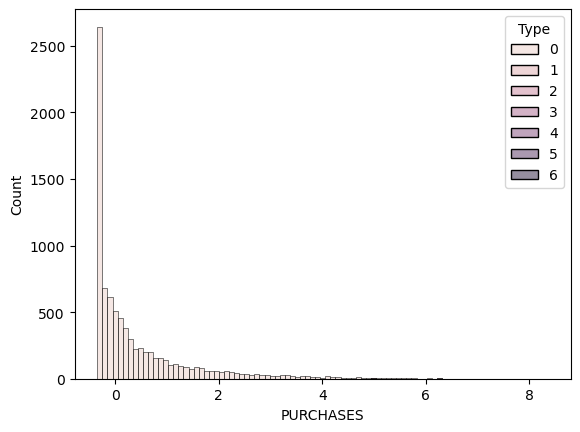

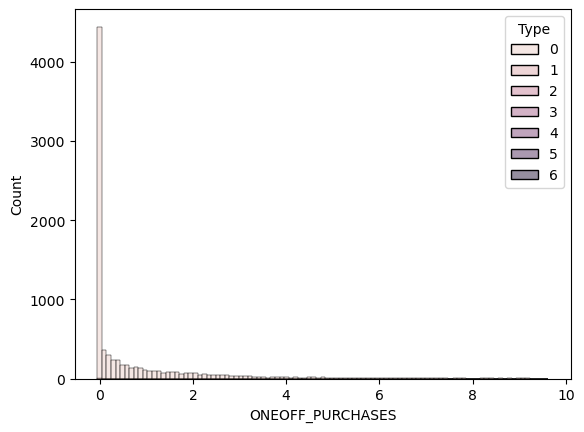

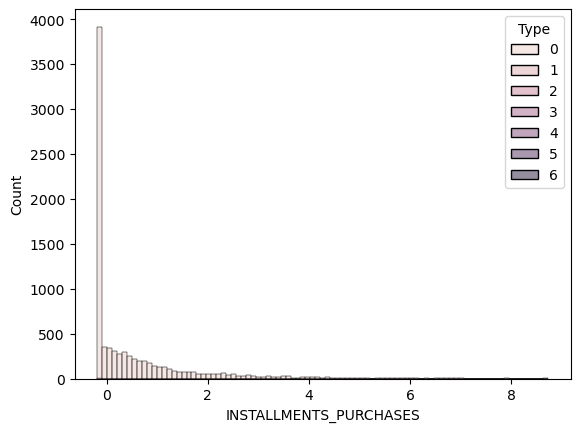

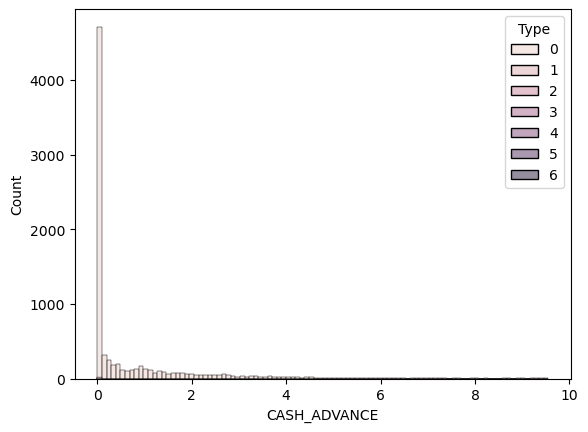

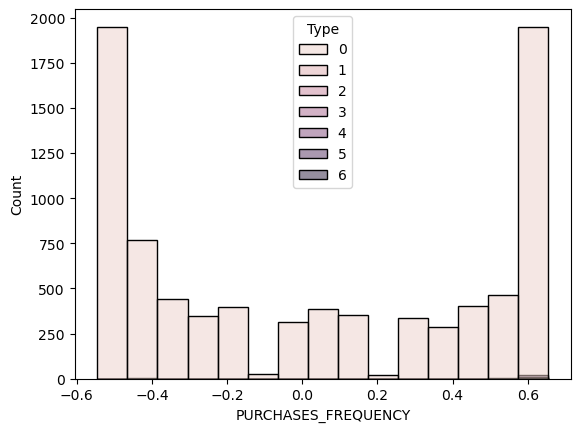

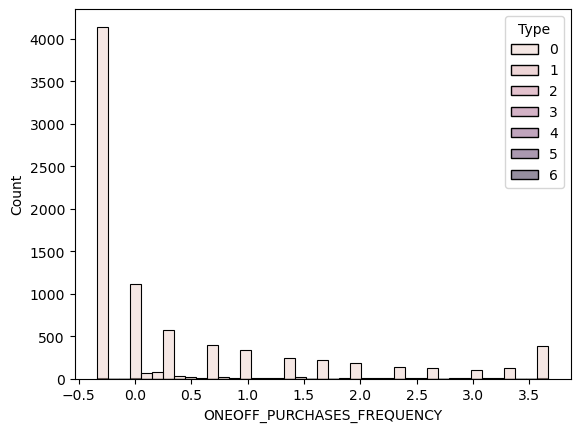

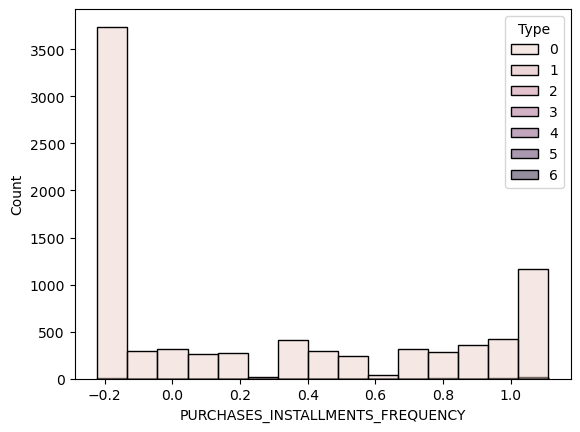

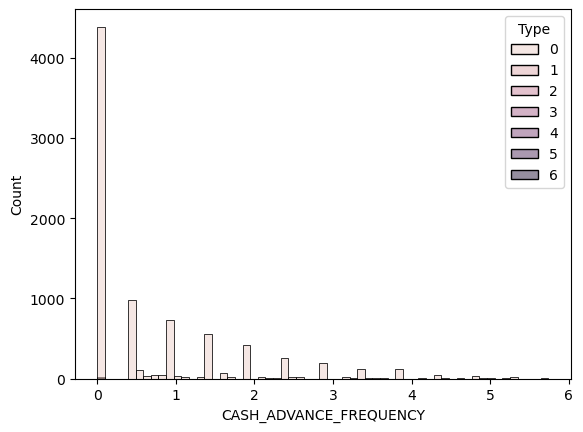

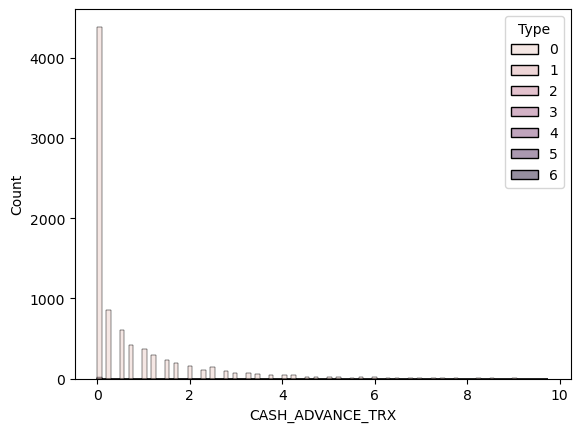

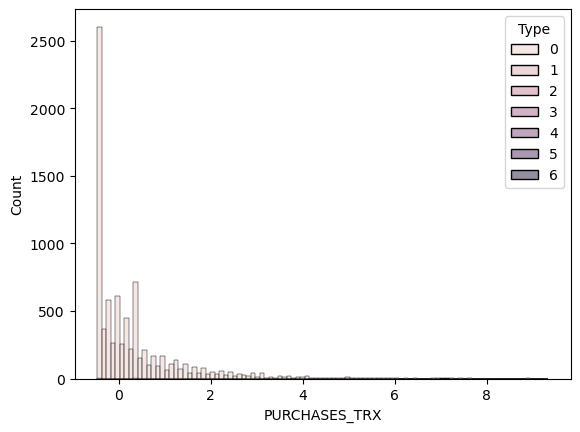

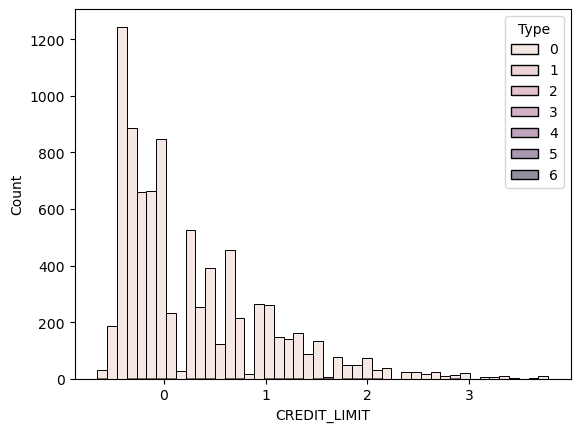

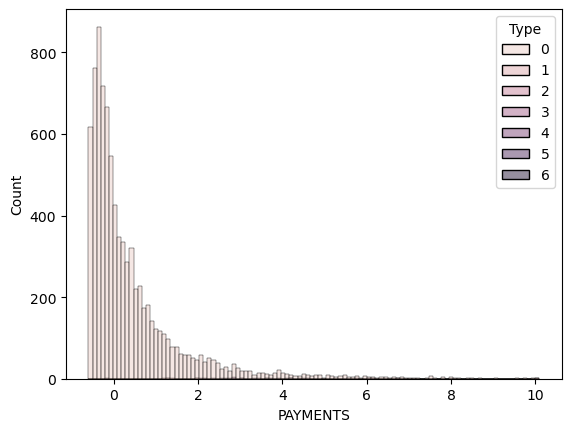

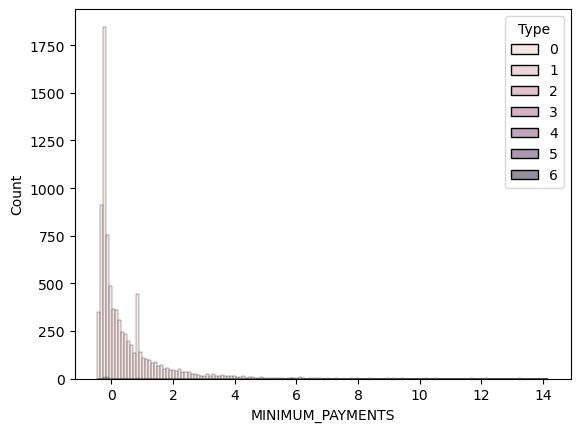

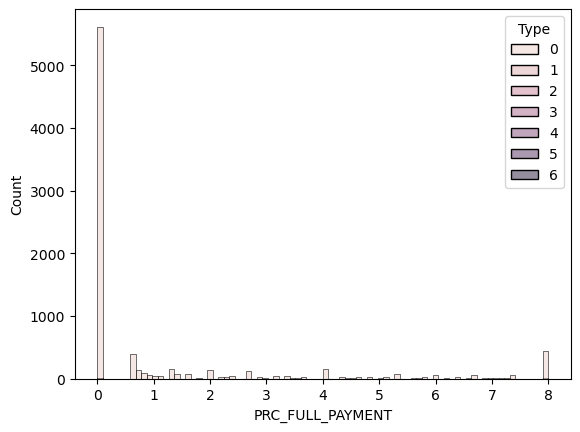

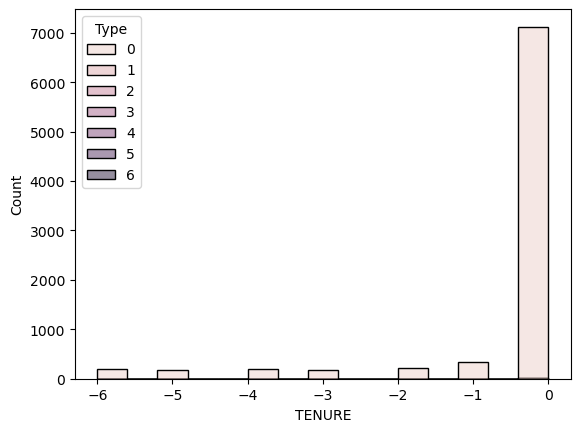

In [29]:
plot_dist(X)

In [30]:
X[X['Type'] < 6].shape

(8481, 18)